In [1]:
import os
import shutil
from pathlib import Path

import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchinfo import summary

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
# Setup device-agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [3]:
# Data path
data_path = Path("data/")
train_path = data_path / "train"
test_path = data_path / "test"

label = []
image_path = []


In [4]:
# Iterate over folders and subfolders to obtain pah
for subfolder in os.listdir(data_path):
    for filename in os.listdir(data_path/subfolder):
        image_path.append(data_path/subfolder/filename)
        label.append(subfolder)

data = np.column_stack([image_path, label])

# Split into test and training data
train_dir, test_dir, train_label, test_label = train_test_split(data[:,0], data[:,1], test_size=0.25)

In [4]:
# NB! Delete or rename previously built directories of the same name.

# Create directory for train data
n = 0
for file in train_dir:
    if not os.path.exists(train_path / train_label[n]):
        os.makedirs(train_path / train_label[n])
    shutil.copy(file, train_path /train_label[n])
    n+=1

# Create directory for test data
i = 0
for file in test_dir:
    if not os.path.exists(test_path / test_label[i]):
        os.makedirs(test_path / test_label[i])
    shutil.copy(file, test_path /test_label[i])
    i+=1

In [5]:
# Write transform for image

train_transform = transforms.Compose([
    # Resize the images to 64x64
    transforms.Resize(size=(64, 64)),

    # Augment training data to improve robustness
    transforms.TrivialAugmentWide(num_magnitude_bins=31),         # Increasing number of bins increases intensity (max = 31), initial 20
    
    # Turn the image into a torch.Tensor
    transforms.ToTensor()                                       # this converts all pixel values from 0 to 255 to be between 0.0 and 1.0 
])

test_transform = transforms.Compose([
    # Resize the images to 64x64
    transforms.Resize(size=(64, 64)),
    
    # Turn the image into a torch.Tensor
    transforms.ToTensor() # this also converts all pixel values from 0 to 255 to be between 0.0 and 1.0 
])

In [6]:
train_data = datasets.ImageFolder(root=train_path, # target folder of images
                                  transform=train_transform, # transforms to perform on data (images)
                                  target_transform=None) # transforms to perform on labels (if necessary)

test_data = datasets.ImageFolder(root=test_path, 
                                 transform=test_transform)

Train data:
Dataset ImageFolder
    Number of datapoints: 343
    Root location: data\train
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
               TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
               ToTensor()
           )
Test data:
Dataset ImageFolder
    Number of datapoints: 115
    Root location: data\test
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
           )
{'cape gull': 0, 'egyptian goose': 1, 'fish eagle': 2, 'ostrich': 3, 'saddle billed stork': 4}
Image shape: torch.Size([3, 64, 64])
Image datatype: torch.float32
Image label: 0
Label datatype: <class 'int'>
Original shape: torch.Size([3, 64, 64]) -> [color_channels, height, width]
Image permute shape: torch.Size([64, 64, 3]) -> [height, width, color_channels]


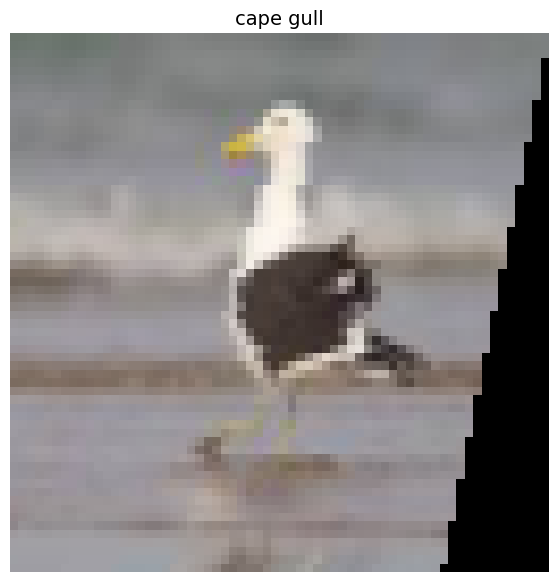

In [7]:
print(f"Train data:\n{train_data}\nTest data:\n{test_data}")

class_dict = train_data.class_to_idx
class_names = train_data.classes
print(class_dict)


# Info for single image
img, label = train_data[0][0], train_data[0][1]
#print(f"Image tensor:\n{img}")
print(f"Image shape: {img.shape}")
print(f"Image datatype: {img.dtype}")
print(f"Image label: {label}")
print(f"Label datatype: {type(label)}")

# Rearrange the order of dimensions
img_permute = img.permute(1, 2, 0)

# Print out different shapes (before and after permute)
print(f"Original shape: {img.shape} -> [color_channels, height, width]")
print(f"Image permute shape: {img_permute.shape} -> [height, width, color_channels]")

# Plot the image
plt.figure(figsize=(10, 7))
plt.imshow(img.permute(1, 2, 0))
plt.axis("off")
plt.title(class_names[label], fontsize=14);

In [8]:
# Turn train and test Datasets into DataLoaders
# DataLoaders makes the dataset iteratable so that the so a model can go through learn the relationships between features and labels.
# See Python documentation for more parameters

batch = 5
cores = os.cpu_count
train_dataloader = DataLoader(dataset=train_data, 
                              batch_size= batch,            # Samples per batch
                              num_workers= 5,               # subprocesses
                              shuffle=True)                 # shuffle data

test_dataloader = DataLoader(dataset=test_data, 
                             batch_size=batch, 
                             num_workers=5, 
                             shuffle=False)

# Check shapes
img, label = next(iter(train_dataloader))

print(f"Image shape: {img.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label.shape}")

Image shape: torch.Size([5, 3, 64, 64]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([5])


In [9]:
class TinyVGG(nn.Module):
    """
    Model architecture copying TinyVGG from: 
    https://poloclub.github.io/cnn-explainer/
    """
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int) -> None:
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, 
                      out_channels=hidden_units, 
                      kernel_size=3, # how big is the square that's going over the image?
                      stride=1, # default
                      padding=1), # options = "valid" (no padding) or "same" (output has same shape as input) or int for specific number 
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, 
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2) # default stride value is same as kernel_size
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            # Where did this in_features shape come from? 
            # It's because each layer of our network compresses and changes the shape of our inputs data.
            nn.Linear(in_features=hidden_units*16*16,
                      out_features=output_shape)
        )
    
    def forward(self, x: torch.Tensor):
        x = self.conv_block_1(x)
        # print(x.shape)
        x = self.conv_block_2(x)
        # print(x.shape)
        x = self.classifier(x)
        # print(x.shape)
        return x
        # return self.classifier(self.conv_block_2(self.conv_block_1(x))) # <- leverage the benefits of operator fusion

torch.manual_seed(42)
model_0 = TinyVGG(input_shape=3, # number of color channels (3 for RGB) 
                  hidden_units=10, 
                  output_shape=len(train_data.classes)).to(device)
model_0

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2560, out_features=5, bias=True)
  )
)

In [10]:
# Try Fwd pass on single image

# 1. Get a batch of images and labels from the DataLoader
img_batch, label_batch = next(iter(train_dataloader))

# 2. Get a single image from the batch and unsqueeze the image so its shape fits the model
img_single, label_single = img_batch[0].unsqueeze(dim=0), label_batch[0]
print(f"Single image shape: {img_single.shape}\n")

# 3. Perform a forward pass on a single image
model_0.eval()
with torch.inference_mode():
    pred = model_0(img_single.to(device))
    
# 4. Print out what's happening and convert model logits -> pred probs -> pred label
print(f"Output logits:\n{pred}\n")
print(f"Output prediction probabilities:\n{torch.softmax(pred, dim=1)}\n")
print(f"Output prediction label:\n{torch.argmax(torch.softmax(pred, dim=1), dim=1)}\n")
print(f"Actual label:\n{label_single}")

Single image shape: torch.Size([1, 3, 64, 64])

Output logits:
tensor([[ 0.0763,  0.0372,  0.0241, -0.0142, -0.0273]])

Output prediction probabilities:
tensor([[0.2116, 0.2035, 0.2008, 0.1933, 0.1908]])

Output prediction label:
tensor([0])

Actual label:
3


In [11]:
summary(model_0, input_size=[1, 3, 64, 64]) # do a test pass through of an example input size

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 5]                    --
├─Sequential: 1-1                        [1, 10, 32, 32]           --
│    └─Conv2d: 2-1                       [1, 10, 64, 64]           280
│    └─ReLU: 2-2                         [1, 10, 64, 64]           --
│    └─Conv2d: 2-3                       [1, 10, 64, 64]           910
│    └─ReLU: 2-4                         [1, 10, 64, 64]           --
│    └─MaxPool2d: 2-5                    [1, 10, 32, 32]           --
├─Sequential: 1-2                        [1, 10, 16, 16]           --
│    └─Conv2d: 2-6                       [1, 10, 32, 32]           910
│    └─ReLU: 2-7                         [1, 10, 32, 32]           --
│    └─Conv2d: 2-8                       [1, 10, 32, 32]           910
│    └─ReLU: 2-9                         [1, 10, 32, 32]           --
│    └─MaxPool2d: 2-10                   [1, 10, 16, 16]           --
├─Sequentia

In [12]:
# Create test and training loop functions

def train_step(model: torch.nn.Module, 
               dataloader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               optimizer: torch.optim.Optimizer):
    # Put model in train mode
    model.train()
    
    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0
    
    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item() 

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate and accumulate accuracy metric across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch 
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

def test_step(model: torch.nn.Module, 
              dataloader: torch.utils.data.DataLoader, 
              loss_fn: torch.nn.Module):
    # Put model in eval mode
    model.eval() 
    
    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0
    
    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)
    
            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()
            
            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))
            
    # Adjust metrics to get average loss and accuracy per batch 
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

from tqdm.auto import tqdm

# 1. Take in various parameters required for training and test steps
def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5):
    
    # 2. Create empty results dictionary
    results = {"train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }
    
    # 3. Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer)
        test_loss, test_acc = test_step(model=model,
            dataloader=test_dataloader,
            loss_fn=loss_fn)
        
        # 4. Print out what's happening
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )

        # 5. Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    # 6. Return the filled results at the end of the epochs
    return results

# Effect of Batch Size

In [13]:
# Turn train and test Datasets into DataLoaders
# DataLoaders makes the dataset iteratable so that the so a model can go through learn the relationships between features and labels.
# See Python documentation for more parameters

batch1 = 8
batch2 = 16
batch3 = 32


cores = os.cpu_count
train_dataloader_8 = DataLoader(dataset=train_data, 
                              batch_size= batch1, # how many samples per batch?
                              num_workers= 4, # how many subprocesses to use for data loading? (higher = more)
                              shuffle=True) # shuffle data

train_dataloader_16 = DataLoader(dataset=train_data, 
                              batch_size= batch2, # how many samples per batch?
                              num_workers= 4, # how many subprocesses to use for data loading? (higher = more)
                              shuffle=True) # shuffle data

train_dataloader_32 = DataLoader(dataset=train_data, 
                              batch_size= batch3, # how many samples per batch?
                              num_workers= 4, # how many subprocesses to use for data loading? (higher = more)
                              shuffle=True) # shuffle data

test_dataloader = DataLoader(dataset=test_data, 
                             batch_size=batch3, 
                             num_workers=4, 
                             shuffle=False) # don't usually need to shuffle testing data

# Check shapes
img_8, label_8 = next(iter(train_dataloader_8))
img_16, label_16 = next(iter(train_dataloader_16))
img_32, label_32 = next(iter(train_dataloader_32))

print(f"Image shape: {img_8.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label_8.shape}")
print(f"Image shape: {img_16.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label_16.shape}")
print(f"Image shape: {img_32.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label_32.shape}")

Image shape: torch.Size([8, 3, 64, 64]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([8])
Image shape: torch.Size([16, 3, 64, 64]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([16])
Image shape: torch.Size([32, 3, 64, 64]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([32])


## Model 0

In [14]:
# Set random seeds
torch.manual_seed(42) 
torch.cuda.manual_seed(42)

# Set number of epochs
NUM_EPOCHS = 50

# Recreate an instance of TinyVGG
model_0 = TinyVGG(input_shape=3, # number of color channels (3 for RGB) 
                  hidden_units=6, 
                  output_shape=len(train_data.classes)).to(device)

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(), lr=0.0005)

# Start the timer
from timeit import default_timer as timer 
start_time = timer()

# Train model_0 
model_0_results = train(model=model_0, 
                        train_dataloader=train_dataloader_8,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer,
                        loss_fn=loss_fn, 
                        epochs=NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

# Reduction in batch size (from 10 5) and learning rate (0.001) greatly improved model, however, it is overfit to training data
# 8 is too many layers, 4 too little, 6 looking good (so far...)

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.6148 | train_acc: 0.1400 | test_loss: 1.6306 | test_acc: 0.1328
Epoch: 2 | train_loss: 1.6142 | train_acc: 0.2097 | test_loss: 1.6252 | test_acc: 0.2969
Epoch: 3 | train_loss: 1.6108 | train_acc: 0.2072 | test_loss: 1.6267 | test_acc: 0.1460
Epoch: 4 | train_loss: 1.6106 | train_acc: 0.2126 | test_loss: 1.6160 | test_acc: 0.1328
Epoch: 5 | train_loss: 1.6057 | train_acc: 0.2363 | test_loss: 1.6182 | test_acc: 0.1460
Epoch: 6 | train_loss: 1.6018 | train_acc: 0.2446 | test_loss: 1.6098 | test_acc: 0.2961
Epoch: 7 | train_loss: 1.5957 | train_acc: 0.2301 | test_loss: 1.5800 | test_acc: 0.2993
Epoch: 8 | train_loss: 1.5769 | train_acc: 0.2562 | test_loss: 1.5342 | test_acc: 0.3096
Epoch: 9 | train_loss: 1.5426 | train_acc: 0.3123 | test_loss: 1.5166 | test_acc: 0.3581
Epoch: 10 | train_loss: 1.5202 | train_acc: 0.3065 | test_loss: 1.4905 | test_acc: 0.3376
Epoch: 11 | train_loss: 1.5262 | train_acc: 0.3360 | test_loss: 1.5666 | test_acc: 0.3368
Epoch: 12 | train_l

### Plot Loss Curve

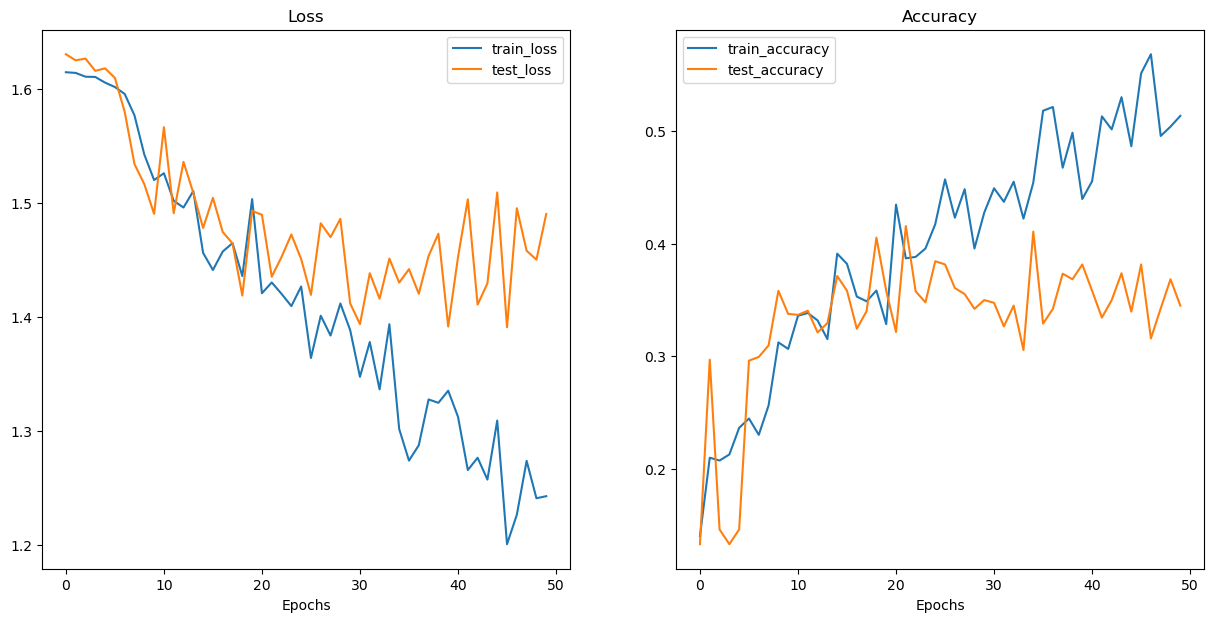

In [17]:
model_0_results.keys()

def plot_loss_curves(results: dict[str, list[float]]):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
    """
    
    # Get the loss values of the results dictionary (training and test)
    loss = results['train_loss']
    test_loss = results['test_loss']

    # Get the accuracy values of the results dictionary (training and test)
    accuracy = results['train_acc']
    test_accuracy = results['test_acc']

    # Figure out how many epochs there were
    epochs = range(len(results['train_loss']))

    # Setup a plot 
    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='train_accuracy')
    plt.plot(epochs, test_accuracy, label='test_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();

#Check the model_0_results keys
plot_loss_curves(model_0_results)

## Model 1

In [19]:
# Create model_1 and send it to the target device
torch.manual_seed(42)
model_1 = TinyVGG(
    input_shape=3,
    hidden_units=6,
    output_shape=len(train_data.classes)).to(device)

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.6154 | train_acc: 0.1656 | test_loss: 1.6170 | test_acc: 0.2969
Epoch: 2 | train_loss: 1.6083 | train_acc: 0.2204 | test_loss: 1.6309 | test_acc: 0.1328
Epoch: 3 | train_loss: 1.6093 | train_acc: 0.2297 | test_loss: 1.6281 | test_acc: 0.1328
Epoch: 4 | train_loss: 1.6097 | train_acc: 0.2261 | test_loss: 1.6361 | test_acc: 0.1328
Epoch: 5 | train_loss: 1.6066 | train_acc: 0.2224 | test_loss: 1.6194 | test_acc: 0.1328
Epoch: 6 | train_loss: 1.6016 | train_acc: 0.2139 | test_loss: 1.6091 | test_acc: 0.2915
Epoch: 7 | train_loss: 1.6063 | train_acc: 0.2346 | test_loss: 1.6130 | test_acc: 0.1406
Epoch: 8 | train_loss: 1.5828 | train_acc: 0.2638 | test_loss: 1.5982 | test_acc: 0.2167
Epoch: 9 | train_loss: 1.5654 | train_acc: 0.2817 | test_loss: 1.5762 | test_acc: 0.2430
Epoch: 10 | train_loss: 1.5316 | train_acc: 0.3283 | test_loss: 1.5151 | test_acc: 0.3951
Epoch: 11 | train_loss: 1.5668 | train_acc: 0.2812 | test_loss: 1.5360 | test_acc: 0.3721
Epoch: 12 | train_l

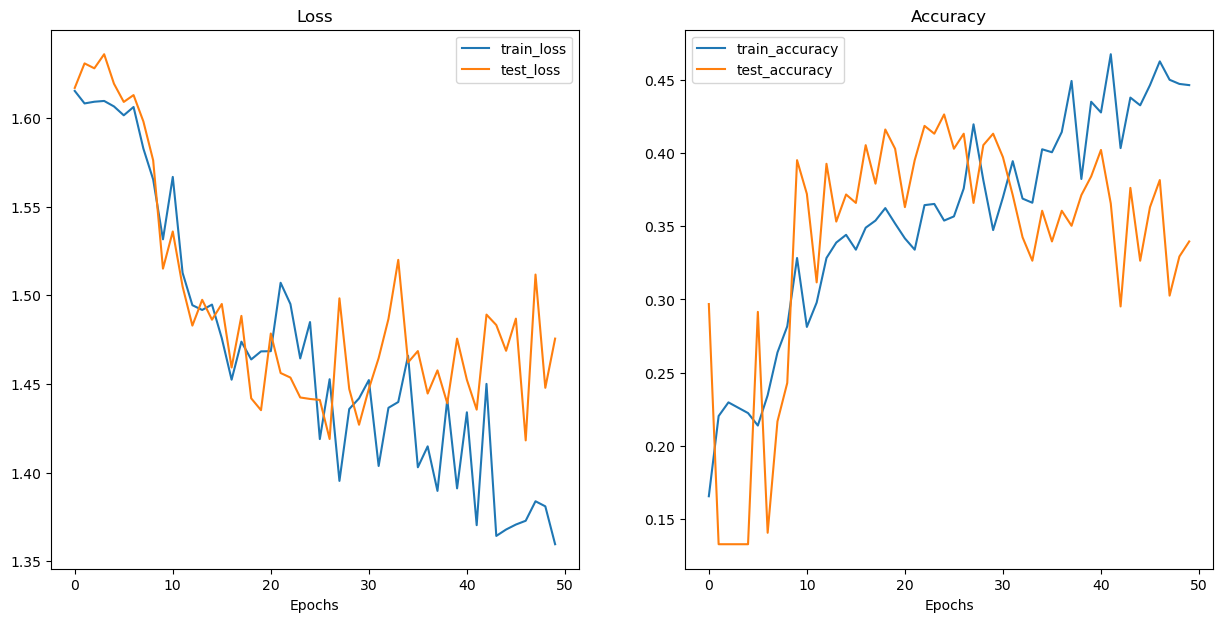

In [20]:
# Set random seeds
torch.manual_seed(42) 
torch.cuda.manual_seed(42)

# Set number of epochs
NUM_EPOCHS = 50

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_1.parameters(), lr=0.0005)

# Start the timer
from timeit import default_timer as timer 
start_time = timer()

# Train model_1
model_1_results = train(model=model_1, 
                        train_dataloader=train_dataloader_16,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer,
                        loss_fn=loss_fn, 
                        epochs=NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

plot_loss_curves(model_1_results)

## Model 2

In [21]:
# Create model_2 and send it to the target device
torch.manual_seed(42)
model_2 = TinyVGG(
    input_shape=3,
    hidden_units=6,
    output_shape=len(train_data.classes)).to(device)

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.6146 | train_acc: 0.1789 | test_loss: 1.6180 | test_acc: 0.1328
Epoch: 2 | train_loss: 1.6077 | train_acc: 0.2265 | test_loss: 1.6319 | test_acc: 0.1328
Epoch: 3 | train_loss: 1.6078 | train_acc: 0.2265 | test_loss: 1.6326 | test_acc: 0.1328
Epoch: 4 | train_loss: 1.6088 | train_acc: 0.2232 | test_loss: 1.6386 | test_acc: 0.1328
Epoch: 5 | train_loss: 1.6071 | train_acc: 0.2243 | test_loss: 1.6220 | test_acc: 0.1328
Epoch: 6 | train_loss: 1.6067 | train_acc: 0.2243 | test_loss: 1.6235 | test_acc: 0.1328
Epoch: 7 | train_loss: 1.6062 | train_acc: 0.2481 | test_loss: 1.6257 | test_acc: 0.1460
Epoch: 8 | train_loss: 1.6014 | train_acc: 0.2260 | test_loss: 1.6236 | test_acc: 0.1328
Epoch: 9 | train_loss: 1.5919 | train_acc: 0.2565 | test_loss: 1.6064 | test_acc: 0.2196
Epoch: 10 | train_loss: 1.5835 | train_acc: 0.2448 | test_loss: 1.6077 | test_acc: 0.1669
Epoch: 11 | train_loss: 1.5671 | train_acc: 0.2980 | test_loss: 1.5773 | test_acc: 0.3405
Epoch: 12 | train_l

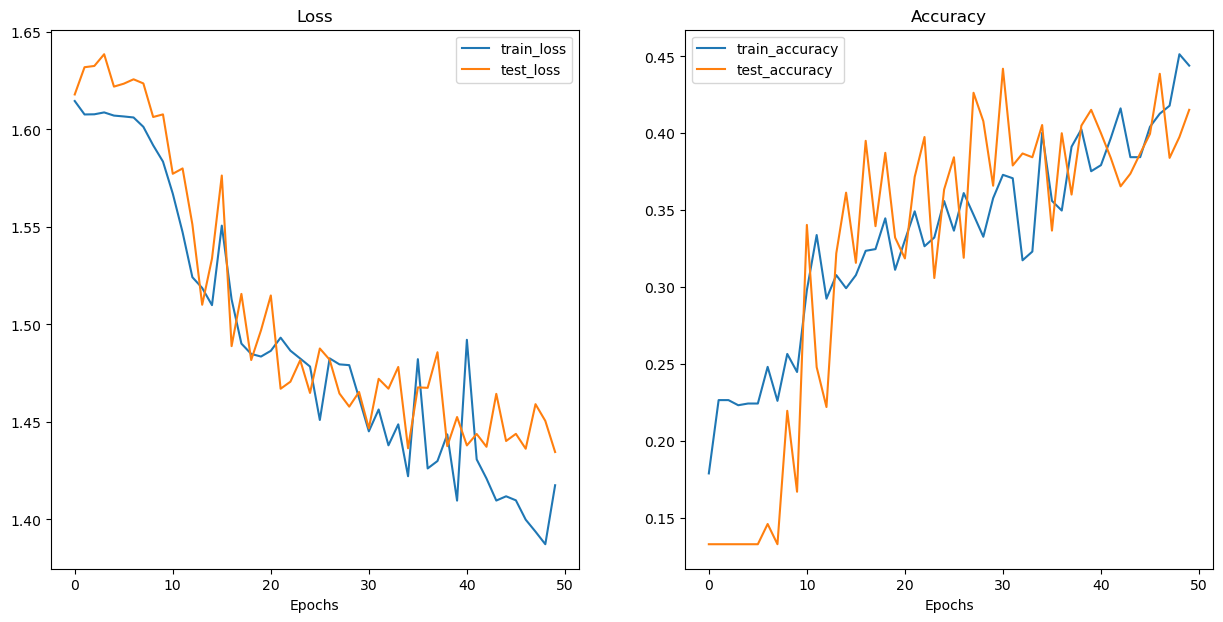

In [23]:
# Set random seeds
torch.manual_seed(42) 
torch.cuda.manual_seed(42)

# Set number of epochs
NUM_EPOCHS = 50 # Initial 10

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_2.parameters(), lr=0.0005)

# Start the timer
from timeit import default_timer as timer 
start_time = timer()

# Train model_2
model_2_results = train(model=model_2, 
                        train_dataloader=train_dataloader_32,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer,
                        loss_fn=loss_fn, 
                        epochs=NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

plot_loss_curves(model_2_results)

## Compare Results

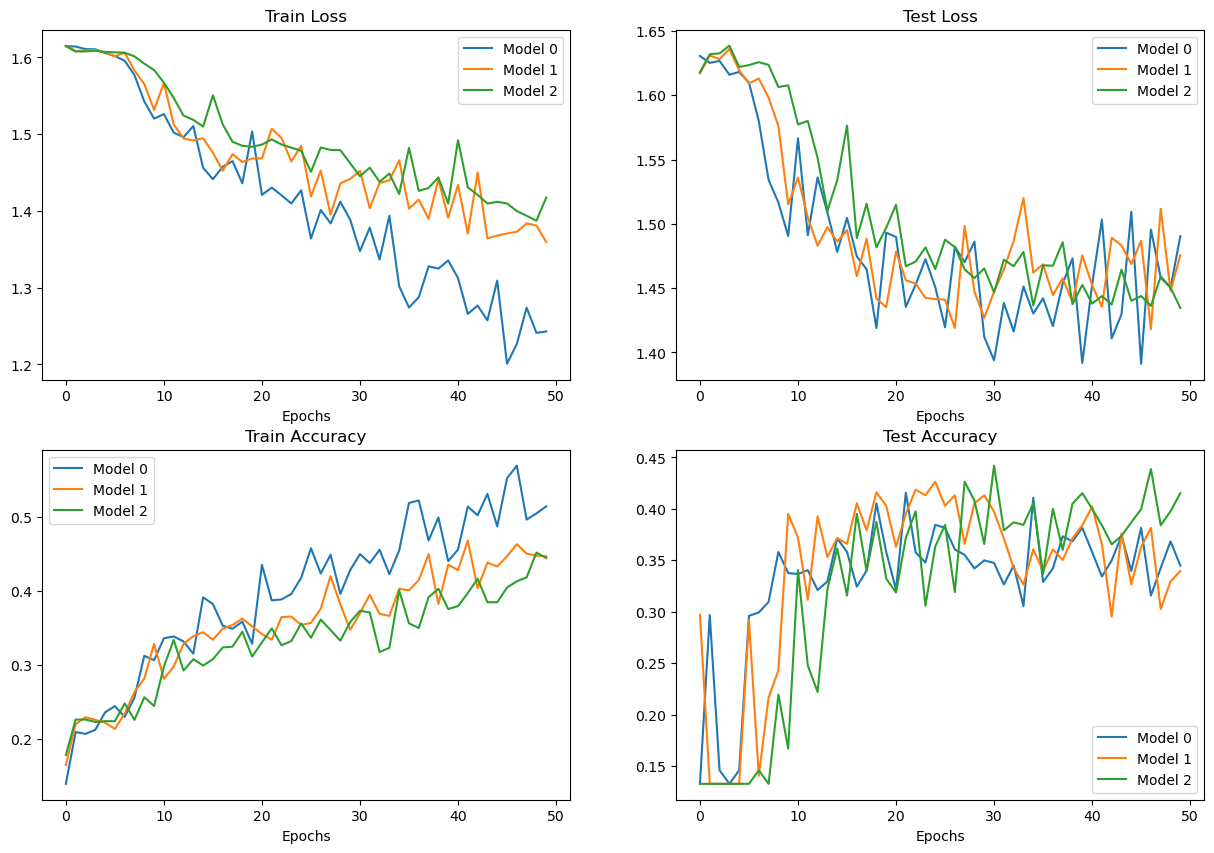

In [24]:
import pandas as pd
model_0_df = pd.DataFrame(model_0_results)
model_1_df = pd.DataFrame(model_1_results)
model_2_df = pd.DataFrame(model_2_results)

# Setup a plot 
plt.figure(figsize=(15, 10))

# Get number of epochs
epochs = range(len(model_0_df))

# Plot train loss
plt.subplot(2, 2, 1)
plt.plot(epochs, model_0_df["train_loss"], label="Model 0")
plt.plot(epochs, model_1_df["train_loss"], label="Model 1")
plt.plot(epochs, model_2_df["train_loss"], label="Model 2")
plt.title("Train Loss")
plt.xlabel("Epochs")
plt.legend()

# Plot test loss
plt.subplot(2, 2, 2)
plt.plot(epochs, model_0_df["test_loss"], label="Model 0")
plt.plot(epochs, model_1_df["test_loss"], label="Model 1")
plt.plot(epochs, model_2_df["test_loss"], label="Model 2")
plt.title("Test Loss")
plt.xlabel("Epochs")
plt.legend()

# Plot train accuracy
plt.subplot(2, 2, 3)
plt.plot(epochs, model_0_df["train_acc"], label="Model 0")
plt.plot(epochs, model_1_df["train_acc"], label="Model 1")
plt.plot(epochs, model_2_df["train_acc"], label="Model 2")
plt.title("Train Accuracy")
plt.xlabel("Epochs")
plt.legend()

# Plot test accuracy
plt.subplot(2, 2, 4)
plt.plot(epochs, model_0_df["test_acc"], label="Model 0")
plt.plot(epochs, model_1_df["test_acc"], label="Model 1")
plt.plot(epochs, model_2_df["test_acc"], label="Model 2")
plt.title("Test Accuracy")
plt.xlabel("Epochs")
plt.legend();

plt.savefig('batch_curves')

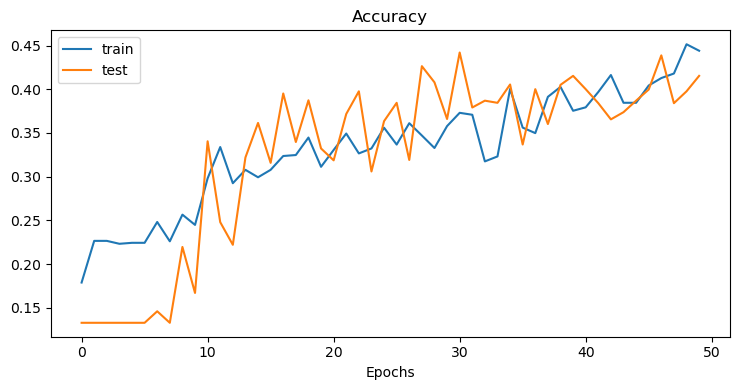

In [33]:
# Plot final model accuracy
plt.figure(figsize=(7.5, 4))

plt.plot(epochs, model_2_df["train_acc"], label = "train")
plt.plot(epochs, model_2_df["test_acc"], label = "test")


plt.title("Accuracy")
plt.xlabel("Epochs")
plt.legend()

plt.tight_layout()

plt.savefig('final_acc')

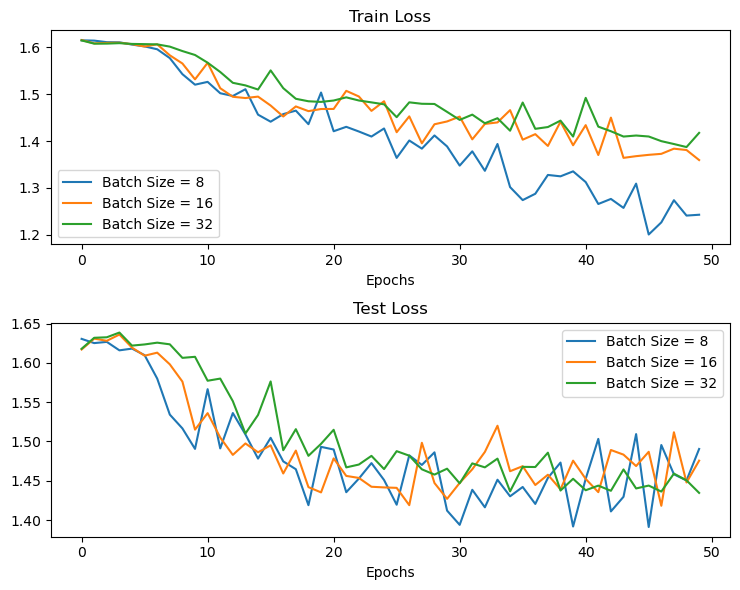

In [30]:
plt.figure(figsize=(7.5, 6))

plt.subplot(2, 1, 1)
plt.plot(epochs, model_0_df["train_loss"], label="Batch Size = 8")
plt.plot(epochs, model_1_df["train_loss"], label="Batch Size = 16")
plt.plot(epochs, model_2_df["train_loss"], label="Batch Size = 32")
plt.title("Train Loss")

plt.xlabel("Epochs")
plt.legend()

# Plot test loss
plt.subplot(2, 1, 2)
plt.plot(epochs, model_0_df["test_loss"], label="Batch Size = 8")
plt.plot(epochs, model_1_df["test_loss"], label="Batch Size = 16")
plt.plot(epochs, model_2_df["test_loss"], label="Batch Size = 32")

plt.title("Test Loss")
plt.xlabel("Epochs")
plt.legend()

plt.tight_layout()

plt.savefig('batch_loss')

## Updated transforms and data loader

In [ ]:
# Write transform for image

train_transform = transforms.Compose([
    # Resize the images to 64x64
    transforms.Resize(size=(64, 64)),

    # Augment training data to improve robustability
    transforms.TrivialAugmentWide(num_magnitude_bins=31), # Increasing number of bins increases intensity (max = 31), initial 20
    
     # Turn the image into a torch.Tensor
     transforms.ToTensor(), # this converts all pixel values from 0 to 255 to be between 0.0 and 1.0
])

test_transform = transforms.Compose([
    # Resize the images to 64x64
    transforms.Resize(size=(64, 64)),
    
    # Turn the image into a torch.Tensor
    transforms.ToTensor(), # this also converts all pixel values from 0 to 255 to be between 0.0 and 1.0 
])

train_data = datasets.ImageFolder(root=train_path, # target folder of images
                                  transform=train_transform, # transforms to perform on data (images)
                                  target_transform=None) # transforms to perform on labels (if necessary)

test_data = datasets.ImageFolder(root=test_path, 
                                 transform=test_transform)

print(f"Train data:\n{train_data1}\nTest data:\n{test_data}")

class_dict = train_data1.class_to_idx
class_names = train_data.classes
print(class_dict)


# Info for single image
img, label = train_data[0][0], train_data[0][1]
#print(f"Image tensor:\n{img}")
print(f"Image shape: {img.shape}")
print(f"Image datatype: {img.dtype}")
print(f"Image label: {label}")
print(f"Label datatype: {type(label)}")

# Rearrange the order of dimensions
img_permute = img.permute(1, 2, 0)

# Print out different shapes (before and after permute)
print(f"Original shape: {img.shape} -> [color_channels, height, width]")
print(f"Image permute shape: {img_permute.shape} -> [height, width, color_channels]")

# Plot the image
plt.figure(figsize=(10, 7))
plt.imshow(img.permute(1, 2, 0))
plt.axis("off")
plt.title(class_names[label], fontsize=14);

# Number of Hidden Layers

In [42]:
# Create model_3 to 5
torch.manual_seed(42)
model_3 = TinyVGG(
    input_shape=3,
    hidden_units=4,
    output_shape=len(train_data.classes)).to(device)
model_3

model_4 = TinyVGG(
    input_shape=3,
    hidden_units=6,
    output_shape=len(train_data.classes)).to(device)
model_4

model_5 = TinyVGG(
    input_shape=3,
    hidden_units=8,
    output_shape=len(train_data.classes)).to(device)
model_5

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2048, out_features=5, bias=True)
  )
)

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.6113 | train_acc: 0.1777 | test_loss: 1.6155 | test_acc: 0.1328
Epoch: 2 | train_loss: 1.6069 | train_acc: 0.2265 | test_loss: 1.6244 | test_acc: 0.1328
Epoch: 3 | train_loss: 1.6068 | train_acc: 0.2265 | test_loss: 1.6287 | test_acc: 0.1328
Epoch: 4 | train_loss: 1.6076 | train_acc: 0.2232 | test_loss: 1.6362 | test_acc: 0.1328
Epoch: 5 | train_loss: 1.6067 | train_acc: 0.2243 | test_loss: 1.6282 | test_acc: 0.1328
Epoch: 6 | train_loss: 1.6068 | train_acc: 0.2243 | test_loss: 1.6268 | test_acc: 0.1328
Epoch: 7 | train_loss: 1.6073 | train_acc: 0.2254 | test_loss: 1.6279 | test_acc: 0.1328
Epoch: 8 | train_loss: 1.6068 | train_acc: 0.2232 | test_loss: 1.6292 | test_acc: 0.1328
Epoch: 9 | train_loss: 1.6051 | train_acc: 0.2310 | test_loss: 1.6254 | test_acc: 0.1328
Epoch: 10 | train_loss: 1.6067 | train_acc: 0.2221 | test_loss: 1.6259 | test_acc: 0.1328
Epoch: 11 | train_loss: 1.6064 | train_acc: 0.2254 | test_loss: 1.6279 | test_acc: 0.1328
Epoch: 12 | train_l

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.6115 | train_acc: 0.2066 | test_loss: 1.6294 | test_acc: 0.1328
Epoch: 2 | train_loss: 1.6094 | train_acc: 0.2243 | test_loss: 1.6236 | test_acc: 0.1328
Epoch: 3 | train_loss: 1.5973 | train_acc: 0.2232 | test_loss: 1.6229 | test_acc: 0.1460
Epoch: 4 | train_loss: 1.5742 | train_acc: 0.2913 | test_loss: 1.5621 | test_acc: 0.3409
Epoch: 5 | train_loss: 1.5521 | train_acc: 0.2805 | test_loss: 1.5214 | test_acc: 0.3951
Epoch: 6 | train_loss: 1.5265 | train_acc: 0.3247 | test_loss: 1.4945 | test_acc: 0.3664
Epoch: 7 | train_loss: 1.5065 | train_acc: 0.3702 | test_loss: 1.5036 | test_acc: 0.3507
Epoch: 8 | train_loss: 1.4865 | train_acc: 0.3140 | test_loss: 1.4854 | test_acc: 0.3877
Epoch: 9 | train_loss: 1.4867 | train_acc: 0.3356 | test_loss: 1.5635 | test_acc: 0.3553
Epoch: 10 | train_loss: 1.4774 | train_acc: 0.3378 | test_loss: 1.4560 | test_acc: 0.3717
Epoch: 11 | train_loss: 1.5059 | train_acc: 0.3203 | test_loss: 1.4736 | test_acc: 0.4054
Epoch: 12 | train_l

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.6203 | train_acc: 0.1942 | test_loss: 1.6149 | test_acc: 0.1328
Epoch: 2 | train_loss: 1.6059 | train_acc: 0.2265 | test_loss: 1.6335 | test_acc: 0.1328
Epoch: 3 | train_loss: 1.6088 | train_acc: 0.2254 | test_loss: 1.6457 | test_acc: 0.1328
Epoch: 4 | train_loss: 1.6071 | train_acc: 0.2221 | test_loss: 1.6284 | test_acc: 0.1328
Epoch: 5 | train_loss: 1.6066 | train_acc: 0.2265 | test_loss: 1.6210 | test_acc: 0.1328
Epoch: 6 | train_loss: 1.6058 | train_acc: 0.2265 | test_loss: 1.6219 | test_acc: 0.1328
Epoch: 7 | train_loss: 1.6093 | train_acc: 0.2221 | test_loss: 1.6351 | test_acc: 0.1328
Epoch: 8 | train_loss: 1.6057 | train_acc: 0.2221 | test_loss: 1.6224 | test_acc: 0.1328
Epoch: 9 | train_loss: 1.6071 | train_acc: 0.2232 | test_loss: 1.6213 | test_acc: 0.1328
Epoch: 10 | train_loss: 1.6052 | train_acc: 0.2276 | test_loss: 1.6182 | test_acc: 0.1328
Epoch: 11 | train_loss: 1.6053 | train_acc: 0.2221 | test_loss: 1.6288 | test_acc: 0.1328
Epoch: 12 | train_l

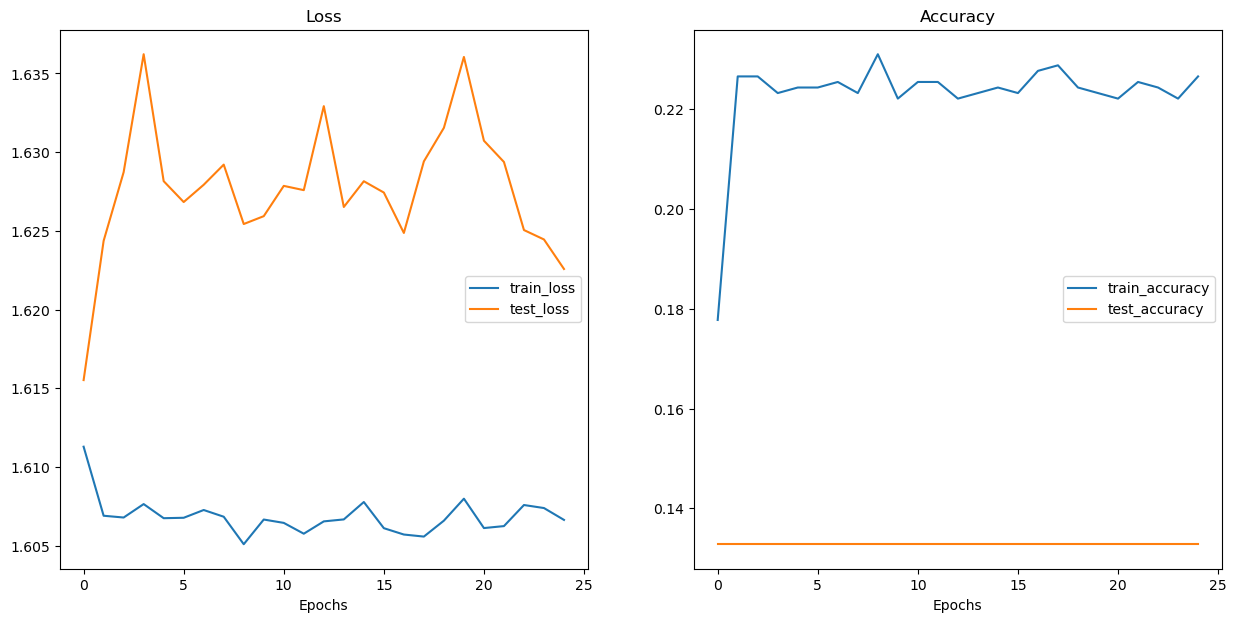

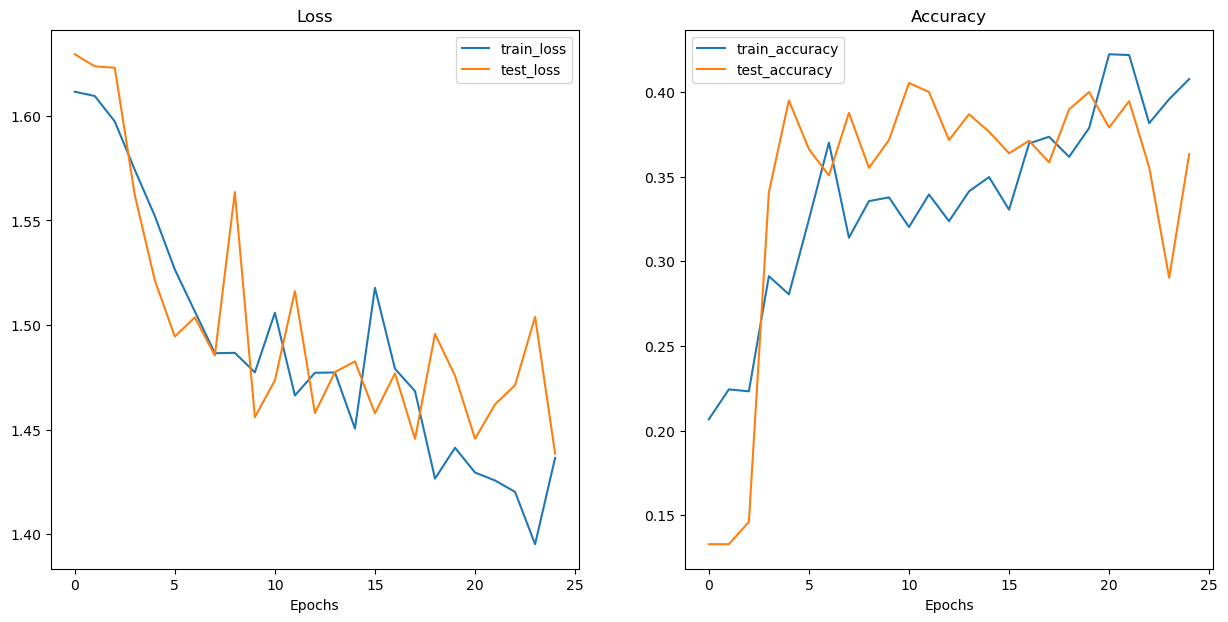

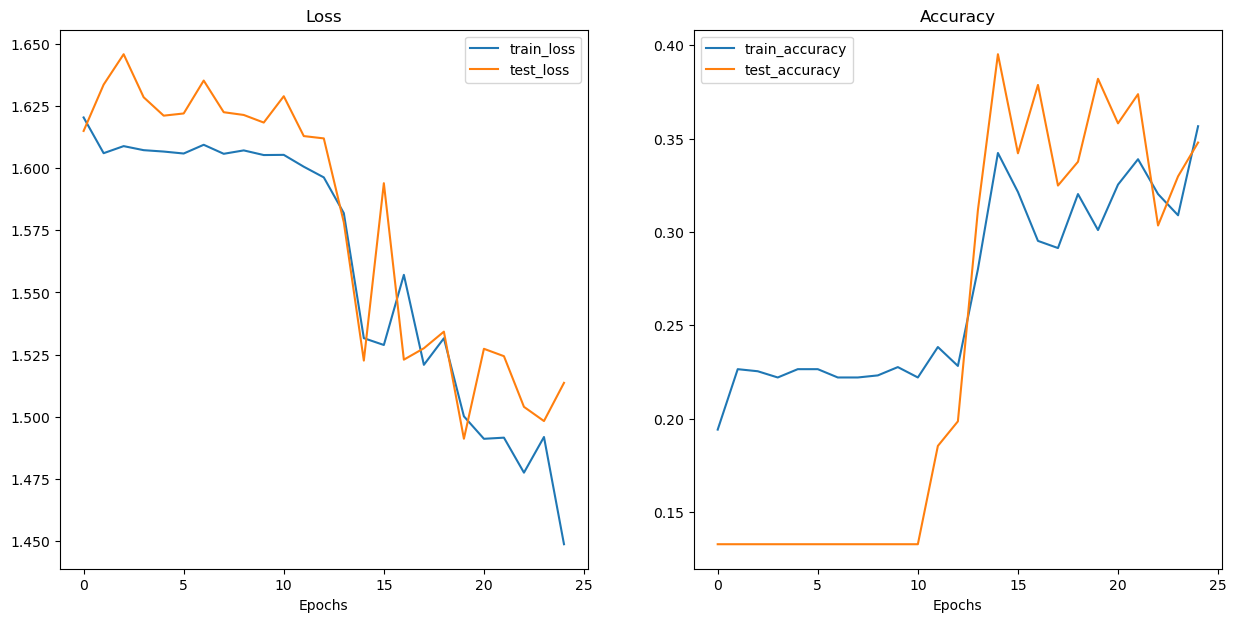

In [43]:
# Set random seeds
torch.manual_seed(42) 
torch.cuda.manual_seed(42)

# Set number of epochs
NUM_EPOCHS = 25 # Initial 10

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_3.parameters(), lr=0.001)

# Start the timer
from timeit import default_timer as timer 
start_time = timer()

# Train model_3
model_3_results = train(model=model_3, 
                        train_dataloader=train_dataloader_32,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer,
                        loss_fn=loss_fn, 
                        epochs=NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

plot_loss_curves(model_3_results)


optimizer = torch.optim.Adam(params=model_4.parameters(), lr=0.001)

# Start the timer
from timeit import default_timer as timer 
start_time = timer()

# Train model_4
model_4_results = train(model=model_4, 
                        train_dataloader=train_dataloader_32,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer,
                        loss_fn=loss_fn, 
                        epochs=NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

plot_loss_curves(model_4_results)

# Start the timer
from timeit import default_timer as timer 
start_time = timer()

optimizer = torch.optim.Adam(params=model_5.parameters(), lr=0.001)

# Train model_5
model_5_results = train(model=model_5, 
                        train_dataloader=train_dataloader_32,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer,
                        loss_fn=loss_fn, 
                        epochs=NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

plot_loss_curves(model_5_results)

## Compare

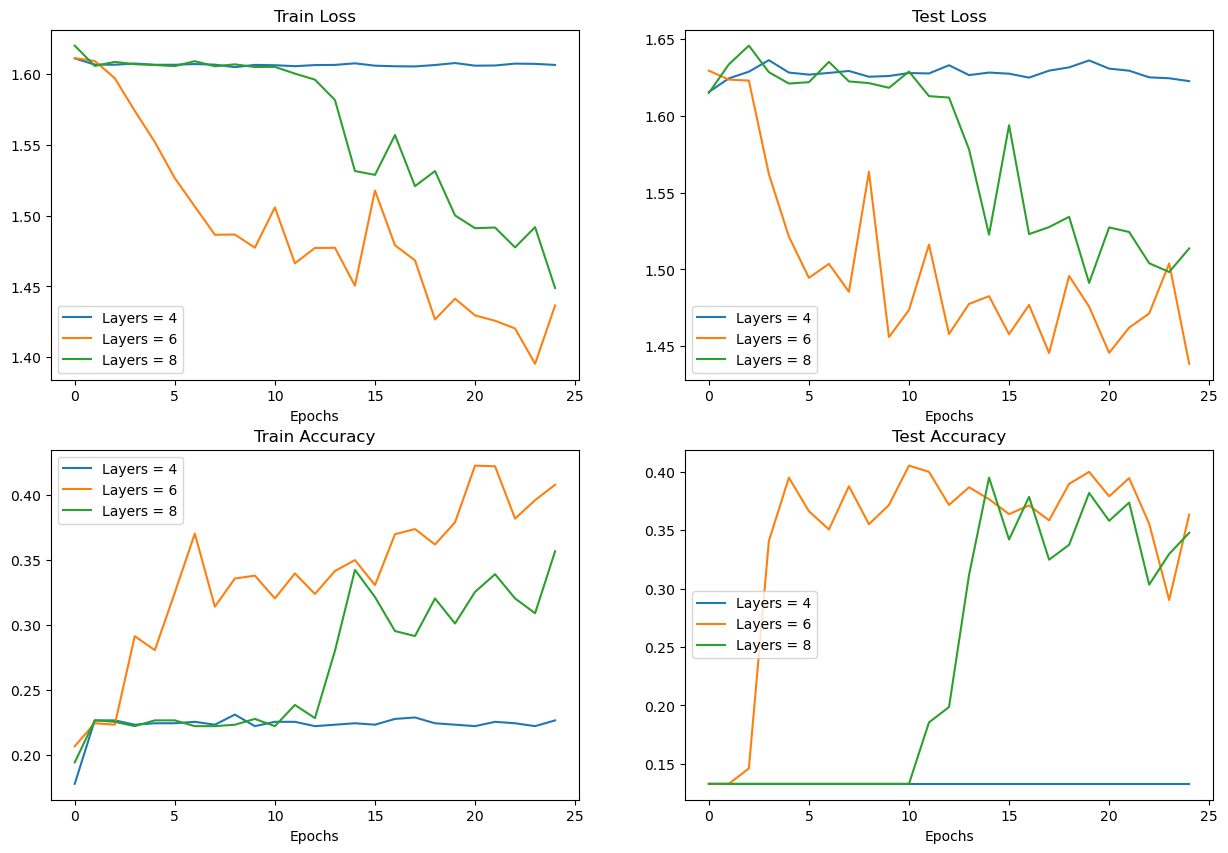

In [44]:
import pandas as pd
model_3_df = pd.DataFrame(model_3_results)
model_4_df = pd.DataFrame(model_4_results)
model_5_df = pd.DataFrame(model_5_results)

# Setup a plot 
plt.figure(figsize=(15, 10))

# Get number of epochs
epochs = range(len(model_3_df))

# Plot train loss
plt.subplot(2, 2, 1)
plt.plot(epochs, model_3_df["train_loss"], label="Layers = 4")
plt.plot(epochs, model_4_df["train_loss"], label="Layers = 6")
plt.plot(epochs, model_5_df["train_loss"], label="Layers = 8")
plt.title("Train Loss")
plt.xlabel("Epochs")
plt.legend()

# Plot test loss
plt.subplot(2, 2, 2)
plt.plot(epochs, model_3_df["test_loss"], label="Layers = 4")
plt.plot(epochs, model_4_df["test_loss"], label="Layers = 6")
plt.plot(epochs, model_5_df["test_loss"], label="Layers = 8")
plt.title("Test Loss")
plt.xlabel("Epochs")
plt.legend()

# Plot train accuracy
plt.subplot(2, 2, 3)
plt.plot(epochs, model_3_df["train_acc"], label="Layers = 4")
plt.plot(epochs, model_4_df["train_acc"], label="Layers = 6")
plt.plot(epochs, model_5_df["train_acc"], label="Layers = 8")
plt.title("Train Accuracy")
plt.xlabel("Epochs")
plt.legend()

# Plot test accuracy
plt.subplot(2, 2, 4)
plt.plot(epochs, model_3_df["test_acc"], label="Layers = 4")
plt.plot(epochs, model_4_df["test_acc"], label="Layers = 6")
plt.plot(epochs, model_5_df["test_acc"], label="Layers = 8")
plt.title("Test Accuracy")
plt.xlabel("Epochs")
plt.legend();

plt.savefig('hidden_layers_curves')

NameError: name 'model_3_df' is not defined

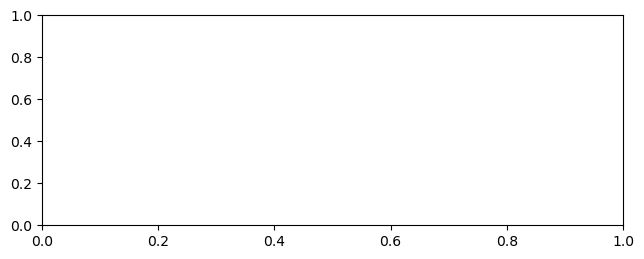

In [29]:
# Plot train loss

plt.figure(figsize=(7.5, 6))

plt.subplot(2, 1, 1)
plt.plot(epochs, model_3_df["train_loss"], label="Layers = 4")
plt.plot(epochs, model_4_df["train_loss"], label="Layers = 6")
plt.plot(epochs, model_5_df["train_loss"], label="Layers = 8")
plt.title("Train Loss")
plt.xlabel("Epochs")
plt.legend()

# Plot test loss
plt.subplot(2, 1, 2)
plt.plot(epochs, model_3_df["test_loss"], label="Layers = 4")
plt.plot(epochs, model_4_df["test_loss"], label="Layers = 6")
plt.plot(epochs, model_5_df["test_loss"], label="Layers = 8")
plt.title("Test Loss")
plt.xlabel("Epochs")
plt.legend()

plt.tight_layout()

plt.savefig('hidden_layers_loss')

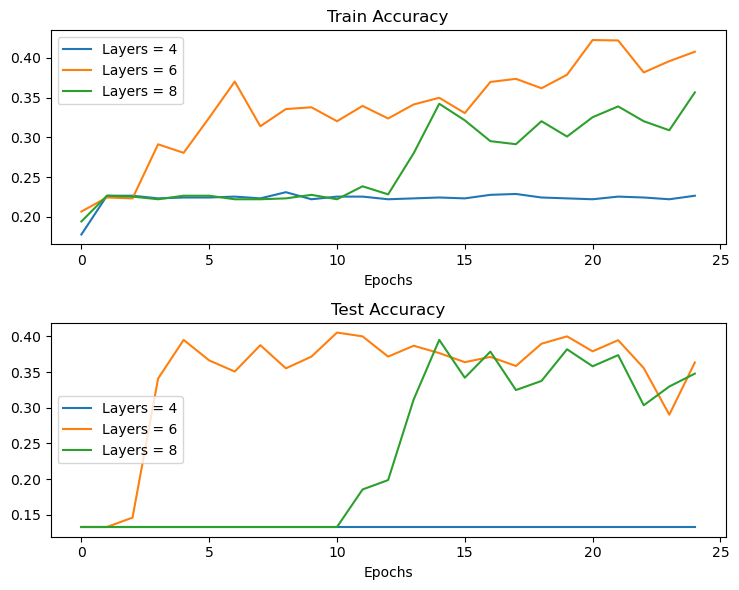

In [84]:
plt.figure(figsize=(7.5, 6))

# Plot train accuracy
plt.subplot(2, 1, 1)
plt.plot(epochs, model_3_df["train_acc"], label="Layers = 4")
plt.plot(epochs, model_4_df["train_acc"], label="Layers = 6")
plt.plot(epochs, model_5_df["train_acc"], label="Layers = 8")
plt.title("Train Accuracy")
plt.xlabel("Epochs")
plt.legend()

# Plot test accuracy
plt.subplot(2, 1, 2)
plt.plot(epochs, model_3_df["test_acc"], label="Layers = 4")
plt.plot(epochs, model_4_df["test_acc"], label="Layers = 6")
plt.plot(epochs, model_5_df["test_acc"], label="Layers = 8")
plt.title("Test Accuracy")
plt.xlabel("Epochs")
plt.legend();

plt.tight_layout()
plt.savefig('hidden_layers_acc')

## Learning Rate

In [45]:
# Create model_6 to 8
torch.manual_seed(42)
model_6 = TinyVGG(
    input_shape=3,
    hidden_units=6,
    output_shape=len(train_data.classes)).to(device)

model_7 = TinyVGG(
    input_shape=3,
    hidden_units=6,
    output_shape=len(train_data.classes)).to(device)


model_8 = TinyVGG(
    input_shape=3,
    hidden_units=6,
    output_shape=len(train_data.classes)).to(device)

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.6146 | train_acc: 0.1789 | test_loss: 1.6180 | test_acc: 0.1328
Epoch: 2 | train_loss: 1.6077 | train_acc: 0.2265 | test_loss: 1.6319 | test_acc: 0.1328
Epoch: 3 | train_loss: 1.6078 | train_acc: 0.2265 | test_loss: 1.6326 | test_acc: 0.1328
Epoch: 4 | train_loss: 1.6088 | train_acc: 0.2232 | test_loss: 1.6386 | test_acc: 0.1328
Epoch: 5 | train_loss: 1.6071 | train_acc: 0.2243 | test_loss: 1.6220 | test_acc: 0.1328
Epoch: 6 | train_loss: 1.6067 | train_acc: 0.2243 | test_loss: 1.6235 | test_acc: 0.1328
Epoch: 7 | train_loss: 1.6062 | train_acc: 0.2481 | test_loss: 1.6257 | test_acc: 0.1460
Epoch: 8 | train_loss: 1.6014 | train_acc: 0.2260 | test_loss: 1.6236 | test_acc: 0.1328
Epoch: 9 | train_loss: 1.5919 | train_acc: 0.2565 | test_loss: 1.6064 | test_acc: 0.2196
Epoch: 10 | train_loss: 1.5835 | train_acc: 0.2448 | test_loss: 1.6077 | test_acc: 0.1669
Epoch: 11 | train_loss: 1.5671 | train_acc: 0.2980 | test_loss: 1.5773 | test_acc: 0.3405
Epoch: 12 | train_l

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.6129 | train_acc: 0.2038 | test_loss: 1.6365 | test_acc: 0.1328
Epoch: 2 | train_loss: 1.6089 | train_acc: 0.2243 | test_loss: 1.6175 | test_acc: 0.1460
Epoch: 3 | train_loss: 1.6006 | train_acc: 0.2260 | test_loss: 1.6255 | test_acc: 0.1562
Epoch: 4 | train_loss: 1.5929 | train_acc: 0.2425 | test_loss: 1.6384 | test_acc: 0.1328
Epoch: 5 | train_loss: 1.5846 | train_acc: 0.2346 | test_loss: 1.6261 | test_acc: 0.1698
Epoch: 6 | train_loss: 1.5785 | train_acc: 0.2793 | test_loss: 1.6140 | test_acc: 0.2299
Epoch: 7 | train_loss: 1.5657 | train_acc: 0.3253 | test_loss: 1.6241 | test_acc: 0.2323
Epoch: 8 | train_loss: 1.5428 | train_acc: 0.3384 | test_loss: 1.5964 | test_acc: 0.2405
Epoch: 9 | train_loss: 1.5271 | train_acc: 0.3056 | test_loss: 1.6197 | test_acc: 0.2064
Epoch: 10 | train_loss: 1.5328 | train_acc: 0.3476 | test_loss: 1.5535 | test_acc: 0.3006
Epoch: 11 | train_loss: 1.5083 | train_acc: 0.3567 | test_loss: 1.5161 | test_acc: 0.3553
Epoch: 12 | train_l

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.6199 | train_acc: 0.1936 | test_loss: 1.6105 | test_acc: 0.2619
Epoch: 2 | train_loss: 1.5944 | train_acc: 0.2481 | test_loss: 1.8416 | test_acc: 0.1484
Epoch: 3 | train_loss: 1.6002 | train_acc: 0.2481 | test_loss: 1.6101 | test_acc: 0.3121
Epoch: 4 | train_loss: 1.6057 | train_acc: 0.2572 | test_loss: 1.6062 | test_acc: 0.3355
Epoch: 5 | train_loss: 1.5949 | train_acc: 0.2783 | test_loss: 1.6084 | test_acc: 0.2751
Epoch: 6 | train_loss: 1.5949 | train_acc: 0.2679 | test_loss: 1.5906 | test_acc: 0.3092
Epoch: 7 | train_loss: 1.5926 | train_acc: 0.2431 | test_loss: 1.5925 | test_acc: 0.3252
Epoch: 8 | train_loss: 1.5820 | train_acc: 0.2794 | test_loss: 1.6425 | test_acc: 0.2381
Epoch: 9 | train_loss: 1.5849 | train_acc: 0.2562 | test_loss: 1.5832 | test_acc: 0.3561
Epoch: 10 | train_loss: 1.5689 | train_acc: 0.2982 | test_loss: 1.6165 | test_acc: 0.3586
Epoch: 11 | train_loss: 1.5627 | train_acc: 0.2805 | test_loss: 1.5803 | test_acc: 0.3150
Epoch: 12 | train_l

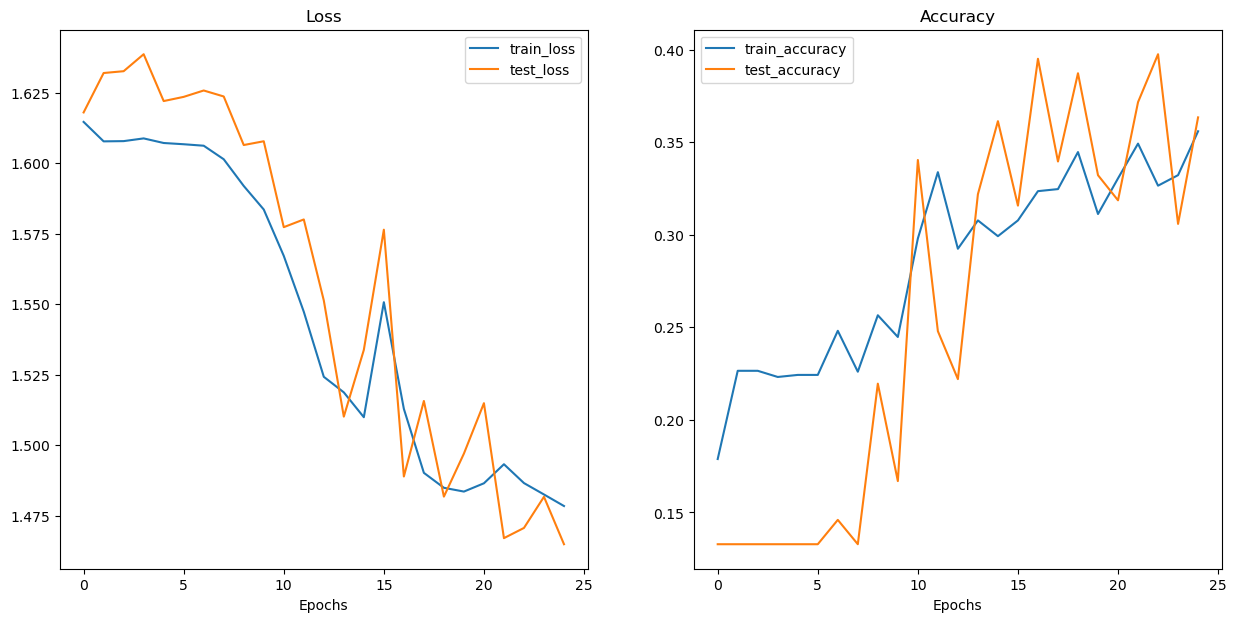

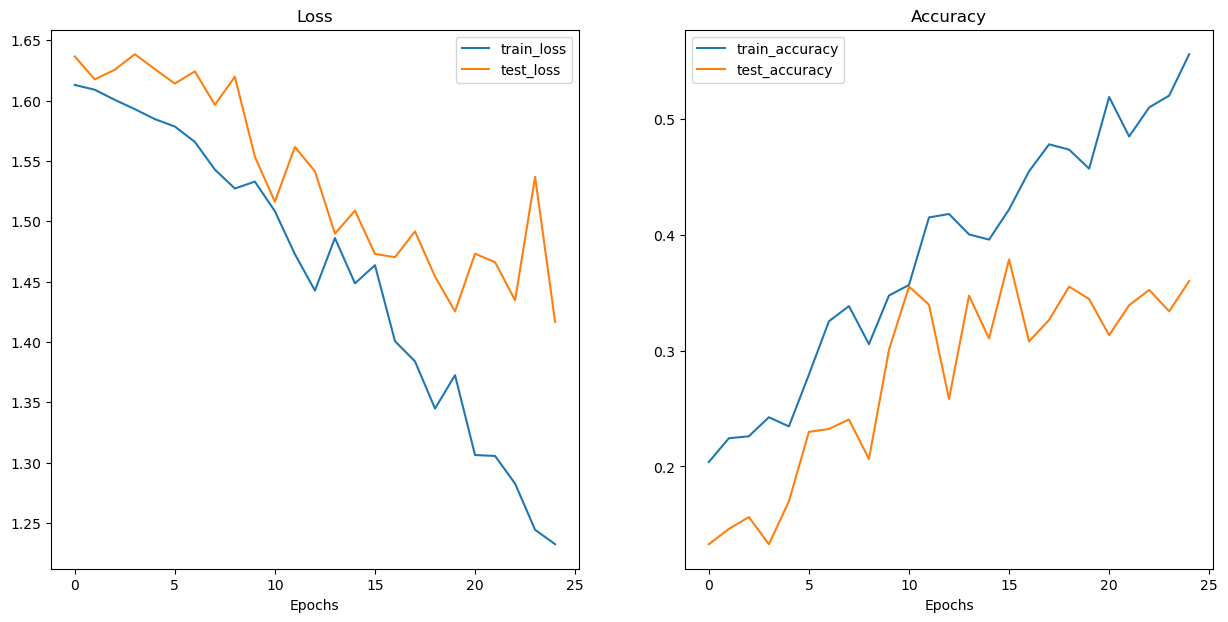

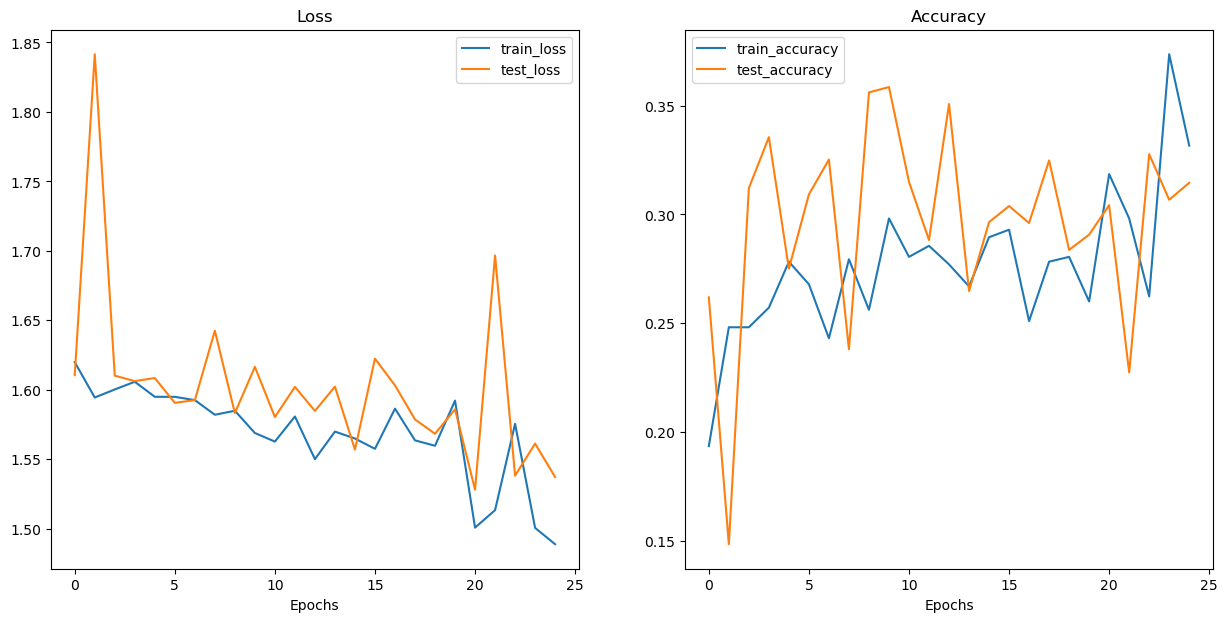

In [46]:
# Set random seeds
torch.manual_seed(42) 
torch.cuda.manual_seed(42)

# Set number of epochs
NUM_EPOCHS = 25 # Initial 10

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_6.parameters(), lr=0.0005)

# Start the timer
from timeit import default_timer as timer 
start_time = timer()

# Train model_6
model_6_results = train(model=model_6, 
                        train_dataloader=train_dataloader_32,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer,
                        loss_fn=loss_fn, 
                        epochs=NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

plot_loss_curves(model_6_results)


optimizer = torch.optim.Adam(params=model_7.parameters(), lr=0.001)

# Start the timer
from timeit import default_timer as timer 
start_time = timer()

# Train model_7
model_7_results = train(model=model_7, 
                        train_dataloader=train_dataloader_32,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer,
                        loss_fn=loss_fn, 
                        epochs=NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

plot_loss_curves(model_7_results)

# Start the timer
from timeit import default_timer as timer 
start_time = timer()

optimizer = torch.optim.Adam(params=model_8.parameters(), lr=0.01)

# Train model_8
model_8_results = train(model=model_8, 
                        train_dataloader=train_dataloader_32,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer,
                        loss_fn=loss_fn, 
                        epochs=NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

plot_loss_curves(model_8_results)

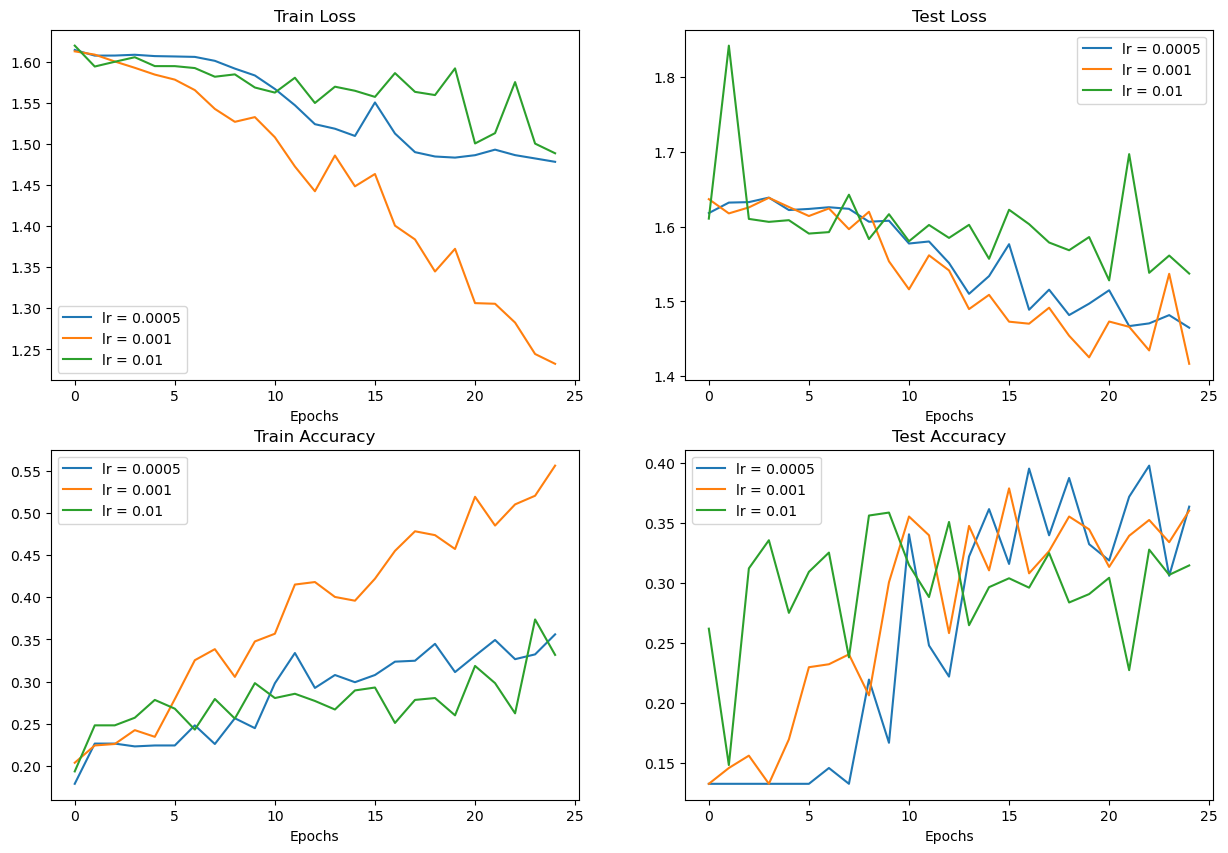

In [47]:
import pandas as pd
model_6_df = pd.DataFrame(model_6_results)
model_7_df = pd.DataFrame(model_7_results)
model_8_df = pd.DataFrame(model_8_results)

# Setup a plot 
plt.figure(figsize=(15, 10))

# Get number of epochs
epochs = range(len(model_6_df))

# Plot train loss
plt.subplot(2, 2, 1)
plt.plot(epochs, model_6_df["train_loss"], label="lr = 0.0005")
plt.plot(epochs, model_7_df["train_loss"], label="lr = 0.001")
plt.plot(epochs, model_8_df["train_loss"], label="lr = 0.01")
plt.title("Train Loss")
plt.xlabel("Epochs")
plt.legend()

# Plot test loss
plt.subplot(2, 2, 2)
plt.plot(epochs, model_6_df["test_loss"], label="lr = 0.0005")
plt.plot(epochs, model_7_df["test_loss"], label="lr = 0.001")
plt.plot(epochs, model_8_df["test_loss"], label="lr = 0.01")
plt.title("Test Loss")
plt.xlabel("Epochs")
plt.legend()

# Plot train accuracy
plt.subplot(2, 2, 3)
plt.plot(epochs, model_6_df["train_acc"], label="lr = 0.0005")
plt.plot(epochs, model_7_df["train_acc"], label="lr = 0.001")
plt.plot(epochs, model_8_df["train_acc"], label="lr = 0.01")
plt.title("Train Accuracy")
plt.xlabel("Epochs")
plt.legend()

# Plot test accuracy
plt.subplot(2, 2, 4)
plt.plot(epochs, model_6_df["test_acc"], label="lr = 0.0005")
plt.plot(epochs, model_7_df["test_acc"], label="lr = 0.001")
plt.plot(epochs, model_8_df["test_acc"], label="lr = 0.01")
plt.title("Test Accuracy")
plt.xlabel("Epochs")
plt.legend();

plt.savefig('learning_rate_curves')

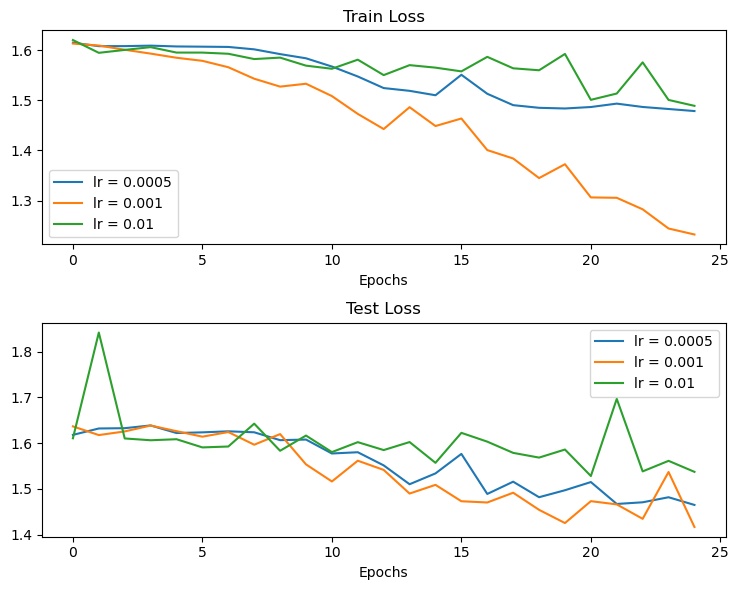

In [81]:
import pandas as pd
model_6_df = pd.DataFrame(model_6_results)
model_7_df = pd.DataFrame(model_7_results)
model_8_df = pd.DataFrame(model_8_results)

# Setup a plot 
plt.figure(figsize=(7.5, 6))

# Get number of epochs
epochs = range(len(model_6_df))

# Plot train loss
plt.subplot(2, 1, 1)
plt.plot(epochs, model_6_df["train_loss"], label="lr = 0.0005")
plt.plot(epochs, model_7_df["train_loss"], label="lr = 0.001")
plt.plot(epochs, model_8_df["train_loss"], label="lr = 0.01")
plt.title("Train Loss")
plt.xlabel("Epochs")
plt.legend()

# Plot test loss
plt.subplot(2, 1, 2)
plt.plot(epochs, model_6_df["test_loss"], label="lr = 0.0005")
plt.plot(epochs, model_7_df["test_loss"], label="lr = 0.001")
plt.plot(epochs, model_8_df["test_loss"], label="lr = 0.01")
plt.title("Test Loss")
plt.xlabel("Epochs")
plt.legend()
plt.tight_layout()

plt.savefig('learning_rate_loss')

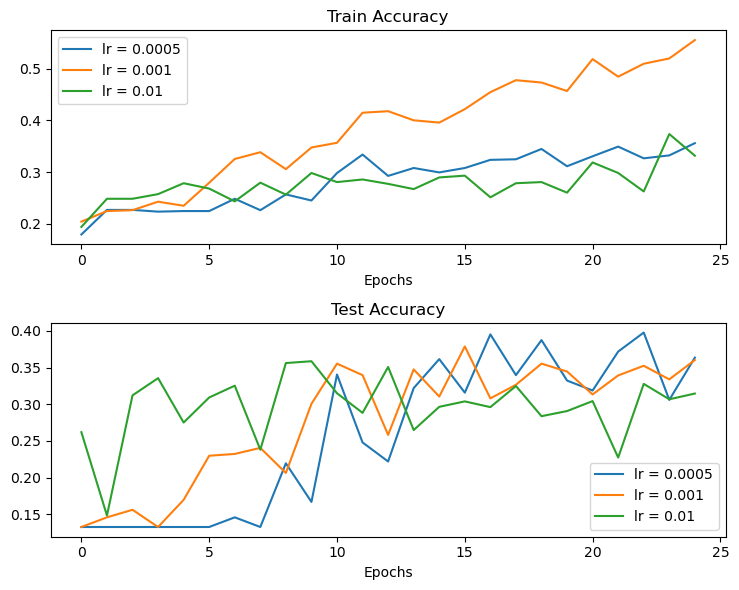

In [85]:
plt.figure(figsize=(7.5, 6))

# Plot train accuracy
plt.subplot(2, 1, 1)
plt.plot(epochs, model_6_df["train_acc"], label="lr = 0.0005")
plt.plot(epochs, model_7_df["train_acc"], label="lr = 0.001")
plt.plot(epochs, model_8_df["train_acc"], label="lr = 0.01")
plt.title("Train Accuracy")
plt.xlabel("Epochs")
plt.legend()

# Plot test accuracy
plt.subplot(2, 1, 2)
plt.plot(epochs, model_6_df["test_acc"], label="lr = 0.0005")
plt.plot(epochs, model_7_df["test_acc"], label="lr = 0.001")
plt.plot(epochs, model_8_df["test_acc"], label="lr = 0.01")
plt.title("Test Accuracy")
plt.xlabel("Epochs")
plt.legend();

plt.tight_layout()
plt.savefig('learning_rate_acc')

# Image Size

In [48]:
# Create model_9 to 11
torch.manual_seed(42)
model_9 = TinyVGG(
    input_shape=3,
    hidden_units=6,
    output_shape=len(train_data.classes)).to(device)

model_10 = TinyVGG(
    input_shape=3,
    hidden_units=6,
    output_shape=len(train_data.classes)).to(device)

model_11 = TinyVGG(
    input_shape=3,
    hidden_units=6,
    output_shape=len(train_data.classes)).to(device)

In [51]:
# Write transform for image
batch = 32

train_transform_32 = transforms.Compose([
    # Resize the images
    transforms.Resize(size=(32, 32)),

    # Augment training data to improve robustability
    transforms.TrivialAugmentWide(num_magnitude_bins=31), # Increasing number of bins increases intensity
    
     # Turn the image into a torch.Tensor
     transforms.ToTensor(), # this converts all pixel values from 0 to 255 to be between 0.0 and 1.0
])

train_transform_64 = transforms.Compose([
    # Resize the images 
    transforms.Resize(size=(64, 64)),

    # Augment training data to improve robustability
    transforms.TrivialAugmentWide(num_magnitude_bins=31), # Increasing number of bins increases intensity
    
     # Turn the image into a torch.Tensor
     transforms.ToTensor(), # this converts all pixel values from 0 to 255 to be between 0.0 and 1.0
])

train_transform_128 = transforms.Compose([
    # Resize the image
    transforms.Resize(size=(128, 128)),

    # Augment training data to improve robustability
    transforms.TrivialAugmentWide(num_magnitude_bins=31), # Increasing number of bins increases intensity
    
     # Turn the image into a torch.Tensor
     transforms.ToTensor(), # this converts all pixel values from 0 to 255 to be between 0.0 and 1.0
])

test_transform_32 = transforms.Compose([
    # Resize the image
    transforms.Resize(size=(32, 32)),
    
    # Turn the image into a torch.Tensor
    transforms.ToTensor(), # this also converts all pixel values from 0 to 255 to be between 0.0 and 1.0 
])

test_transform_64 = transforms.Compose([
    # Resize the images to 64x64
    transforms.Resize(size=(64, 64)),
    
    # Turn the image into a torch.Tensor
    transforms.ToTensor(), # this also converts all pixel values from 0 to 255 to be between 0.0 and 1.0 
])

test_transform_128 = transforms.Compose([
    # Resize the images
    transforms.Resize(size=(128, 128)),
    
    # Turn the image into a torch.Tensor
    transforms.ToTensor(), # this also converts all pixel values from 0 to 255 to be between 0.0 and 1.0 
])

train_data = datasets.ImageFolder(root=train_path, # target folder of images
                                  transform=train_transform_32, # transforms to perform on data (images)
                                  target_transform=None) # transforms to perform on labels (if necessary)

test_data = datasets.ImageFolder(root=test_path, 
                                 transform=test_transform_32)

print(f"Train data:\n{train_data}\nTest data:\n{test_data}")

train_dataloader_32 = DataLoader(dataset=train_data, 
                              batch_size= batch, # how many samples per batch?
                              num_workers= 4, # how many subprocesses to use for data loading? (higher = more)
                              shuffle=True) # shuffle data

test_dataloader_32 = DataLoader(dataset=test_data, 
                             batch_size=batch, 
                             num_workers=4, 
                             shuffle=False) # don't usually need to shuffle testing data

#---------------------------------------------------------------------------------------------------------------

train_data = datasets.ImageFolder(root=train_path, # target folder of images
                                  transform=train_transform_64, # transforms to perform on data (images)
                                  target_transform=None) # transforms to perform on labels (if necessary)

test_data = datasets.ImageFolder(root=test_path, 
                                 transform=test_transform_64)

print(f"Train data:\n{train_data}\nTest data:\n{test_data}")

train_dataloader_64 = DataLoader(dataset=train_data, 
                              batch_size= batch, # how many samples per batch?
                              num_workers= 4, # how many subprocesses to use for data loading? (higher = more)
                              shuffle=True) # shuffle data

test_dataloader_64 = DataLoader(dataset=test_data, 
                             batch_size=batch, 
                             num_workers=4, 
                             shuffle=False) # don't usually need to shuffle testing data

#---------------------------------------------------------------------------------------------------------------

train_data = datasets.ImageFolder(root=train_path, # target folder of images
                                  transform=train_transform_128, # transforms to perform on data (images)
                                  target_transform=None) # transforms to perform on labels (if necessary)

test_data = datasets.ImageFolder(root=test_path, 
                                 transform=test_transform_128)

print(f"Train data:\n{train_data}\nTest data:\n{test_data}")

train_dataloader_128 = DataLoader(dataset=train_data, 
                              batch_size= batch, # how many samples per batch?
                              num_workers= 4, # how many subprocesses to use for data loading? (higher = more)
                              shuffle=True) # shuffle data

test_dataloader_128 = DataLoader(dataset=test_data, 
                             batch_size=batch, 
                             num_workers=4, 
                             shuffle=False) # don't usually need to shuffle testing data

# Check shapes
img_32, label_32 = next(iter(train_dataloader_32))
img_64, label_64 = next(iter(train_dataloader_64))
img_128, label_128 = next(iter(train_dataloader_128))

print(f"Image shape: {img_32.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label_32.shape}")
print(f"Image shape: {img_64.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label_64.shape}")
print(f"Image shape: {img_128.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label_128.shape}")


#class_dict = train_data1.class_to_idx
#class_names = train_data.classes
#print(class_dict)

Train data:
Dataset ImageFolder
    Number of datapoints: 343
    Root location: data\train
    StandardTransform
Transform: Compose(
               Resize(size=(32, 32), interpolation=bilinear, max_size=None, antialias=True)
               TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
               ToTensor()
           )
Test data:
Dataset ImageFolder
    Number of datapoints: 115
    Root location: data\test
    StandardTransform
Transform: Compose(
               Resize(size=(32, 32), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
           )
Train data:
Dataset ImageFolder
    Number of datapoints: 343
    Root location: data\train
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
               TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
               ToTensor()
  

In [52]:
# Set random seeds
lr = 0.0005

torch.manual_seed(42) 
torch.cuda.manual_seed(42)

# Set number of epochs
NUM_EPOCHS = 25 # Initial 10

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_9.parameters(), lr=lr)

# Start the timer
from timeit import default_timer as timer 
start_time = timer()

# Train model_9
model_9_results = train(model=model_9, 
                        train_dataloader=train_dataloader_32,
                        test_dataloader=test_dataloader_32,
                        optimizer=optimizer,
                        loss_fn=loss_fn, 
                        epochs=NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

plot_loss_curves(model_9_results)


optimizer = torch.optim.Adam(params=model_10.parameters(), lr=lr)

# Start the timer
from timeit import default_timer as timer 
start_time = timer()

# Train model_10
model_10_results = train(model=model_10, 
                        train_dataloader=train_dataloader_64,
                        test_dataloader=test_dataloader_64,
                        optimizer=optimizer,
                        loss_fn=loss_fn, 
                        epochs=NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

plot_loss_curves(model_10_results)

# Start the timer
from timeit import default_timer as timer 
start_time = timer()

optimizer = torch.optim.Adam(params=model_11.parameters(), lr=lr)

# Train model_11
model_11_results = train(model=model_11, 
                        train_dataloader=train_dataloader_128,
                        test_dataloader=test_dataloader_128,
                        optimizer=optimizer,
                        loss_fn=loss_fn, 
                        epochs=NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

plot_loss_curves(model_11_results)

  0%|          | 0/25 [00:00<?, ?it/s]

RuntimeError: mat1 and mat2 shapes cannot be multiplied (32x384 and 1536x5)

# Compare

In [ ]:
import pandas as pd
model_9_df = pd.DataFrame(model_9_results)
model_10_df = pd.DataFrame(model_10_results)
model_11_df = pd.DataFrame(model_11_results)

# Setup a plot 
plt.figure(figsize=(15, 10))

# Get number of epochs
epochs = range(len(model_9_df))

# Plot train loss
plt.subplot(2, 2, 1)
plt.plot(epochs, model_9_df["train_loss"], label= "32x32")
plt.plot(epochs, model_10_df["train_loss"], label="64x64)
plt.plot(epochs, model_11_df["train_loss"], label="128x128")
plt.title("Train Loss")
plt.xlabel("Epochs")
plt.legend()

# Plot test loss
plt.subplot(2, 2, 2)
plt.plot(epochs, model_9_df["test_loss"], label= "32x32")
plt.plot(epochs, model_10_df["test_loss"], label="64x64)
plt.plot(epochs, model_11_df["test_loss"], label="128x128")
plt.title("Test Loss")
plt.xlabel("Epochs")
plt.legend()

# Plot train accuracy
plt.subplot(2, 2, 3)
plt.plot(epochs, model_9_df["train_acc"], label= "32x32")
plt.plot(epochs, model_10_df["train_acc"], label="64x64)
plt.plot(epochs, model_11_df["train_acc"], label="128x128")
plt.title("Train Accuracy")
plt.xlabel("Epochs")
plt.legend()

# Plot test accuracy
plt.subplot(2, 2, 4)
plt.plot(epochs, model_9_df["test_acc"], label= "32x32")
plt.plot(epochs, model_10_df["test_acc"], label="64x64)
plt.plot(epochs, model_11_df["test_acc"], label="128x128")
plt.title("Test Accuracy")
plt.xlabel("Epochs")
plt.legend();

plt.savefig('img_size_curves')

In [53]:
# Create model_12 to 14
torch.manual_seed(42)
model_12 = TinyVGG(
    input_shape=3,
    hidden_units=6,
    output_shape=len(train_data.classes)).to(device)

model_13 = TinyVGG(
    input_shape=3,
    hidden_units=6,
    output_shape=len(train_data.classes)).to(device)

model_14 = TinyVGG(
    input_shape=3,
    hidden_units=6,
    output_shape=len(train_data.classes)).to(device)

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.6146 | train_acc: 0.1789 | test_loss: 1.6180 | test_acc: 0.1328
Epoch: 2 | train_loss: 1.6077 | train_acc: 0.2265 | test_loss: 1.6319 | test_acc: 0.1328
Epoch: 3 | train_loss: 1.6078 | train_acc: 0.2265 | test_loss: 1.6326 | test_acc: 0.1328
Epoch: 4 | train_loss: 1.6088 | train_acc: 0.2232 | test_loss: 1.6386 | test_acc: 0.1328
Epoch: 5 | train_loss: 1.6071 | train_acc: 0.2243 | test_loss: 1.6220 | test_acc: 0.1328
Epoch: 6 | train_loss: 1.6067 | train_acc: 0.2243 | test_loss: 1.6235 | test_acc: 0.1328
Epoch: 7 | train_loss: 1.6062 | train_acc: 0.2481 | test_loss: 1.6257 | test_acc: 0.1460
Epoch: 8 | train_loss: 1.6014 | train_acc: 0.2260 | test_loss: 1.6236 | test_acc: 0.1328
Epoch: 9 | train_loss: 1.5919 | train_acc: 0.2565 | test_loss: 1.6064 | test_acc: 0.2196
Epoch: 10 | train_loss: 1.5835 | train_acc: 0.2448 | test_loss: 1.6077 | test_acc: 0.1669
Epoch: 11 | train_loss: 1.5671 | train_acc: 0.2980 | test_loss: 1.5773 | test_acc: 0.3405
Epoch: 12 | train_l

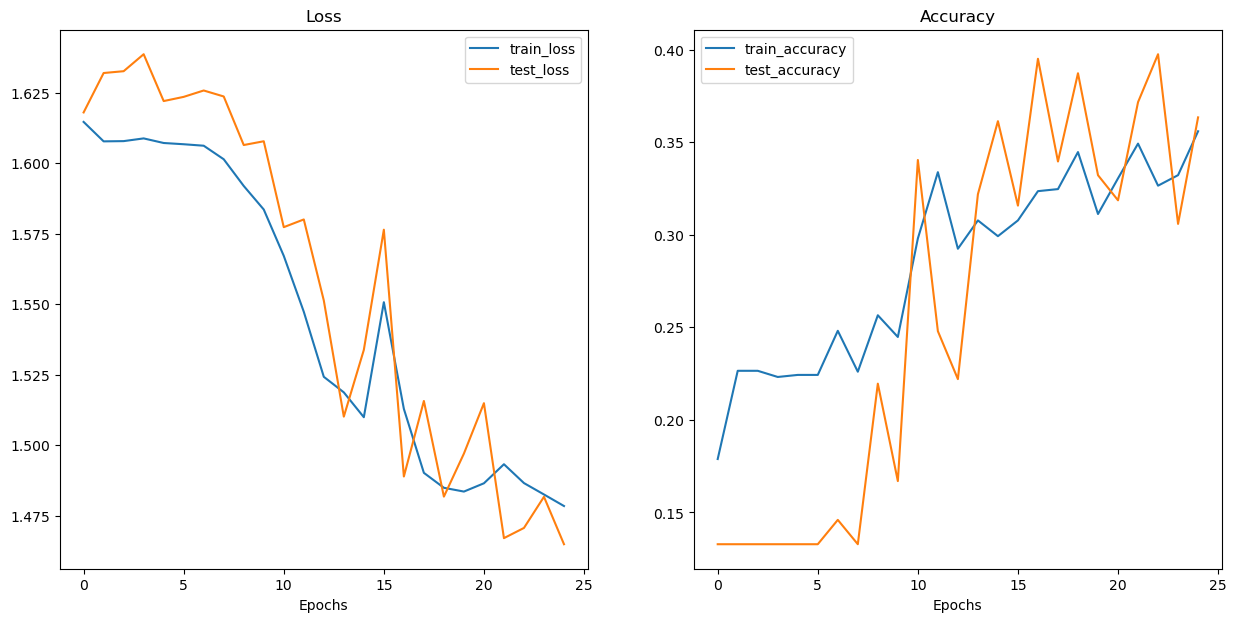

In [54]:
# Set random seeds
lr = 0.0005

torch.manual_seed(42) 
torch.cuda.manual_seed(42)

# Set number of epochs
NUM_EPOCHS = 25

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_12.parameters(), lr=lr)

# Start the timer
from timeit import default_timer as timer 
start_time = timer()

# Train model_21
model_12_results = train(model=model_12, 
                        train_dataloader=train_dataloader_64,
                        test_dataloader=test_dataloader_64,
                        optimizer=optimizer,
                        loss_fn=loss_fn, 
                        epochs=NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

plot_loss_curves(model_12_results)

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.6107 | train_acc: 0.1981 | test_loss: 1.6291 | test_acc: 0.1328
Epoch: 2 | train_loss: 1.6087 | train_acc: 0.2243 | test_loss: 1.6268 | test_acc: 0.1328
Epoch: 3 | train_loss: 1.6057 | train_acc: 0.2232 | test_loss: 1.6341 | test_acc: 0.1328
Epoch: 4 | train_loss: 1.6017 | train_acc: 0.2254 | test_loss: 1.6305 | test_acc: 0.1406
Epoch: 5 | train_loss: 1.5980 | train_acc: 0.2317 | test_loss: 1.6305 | test_acc: 0.1382
Epoch: 6 | train_loss: 1.5967 | train_acc: 0.2254 | test_loss: 1.6210 | test_acc: 0.1986
Epoch: 7 | train_loss: 1.5890 | train_acc: 0.2822 | test_loss: 1.6179 | test_acc: 0.1986
Epoch: 8 | train_loss: 1.5741 | train_acc: 0.3015 | test_loss: 1.6223 | test_acc: 0.2064
Epoch: 9 | train_loss: 1.5684 | train_acc: 0.3078 | test_loss: 1.6241 | test_acc: 0.2747
Epoch: 10 | train_loss: 1.5626 | train_acc: 0.2953 | test_loss: 1.6066 | test_acc: 0.2825
Epoch: 11 | train_loss: 1.5563 | train_acc: 0.3237 | test_loss: 1.5625 | test_acc: 0.2956
Epoch: 12 | train_l

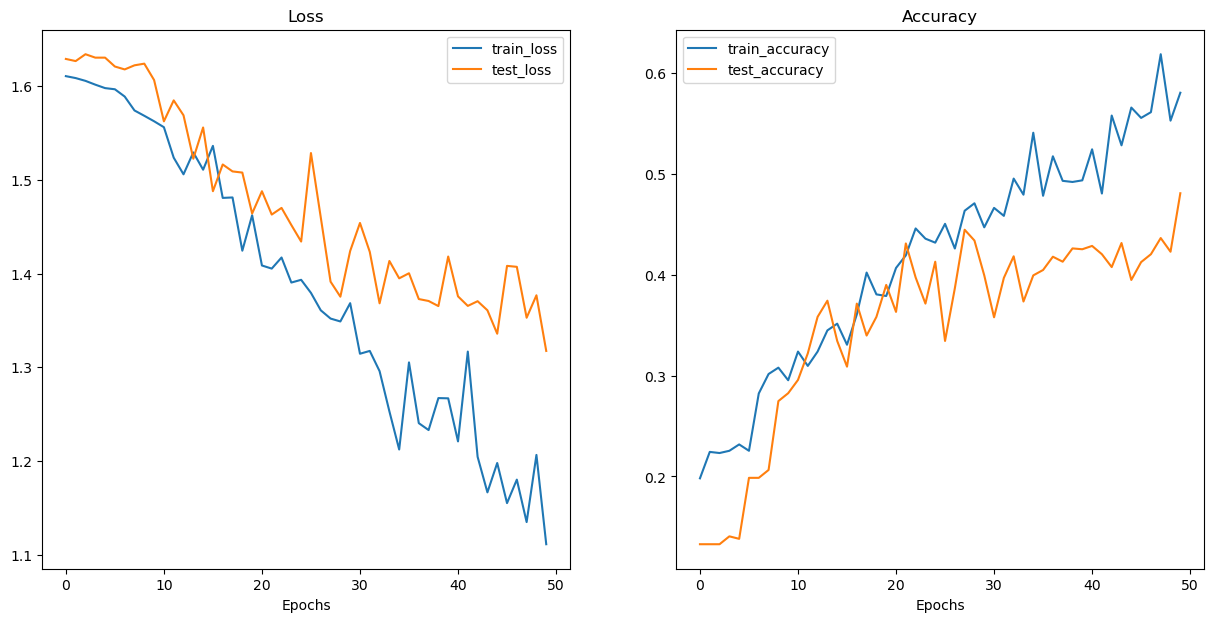

In [55]:
# Set number of epochs
NUM_EPOCHS = 50

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_13.parameters(), lr=lr)

# Start the timer
from timeit import default_timer as timer 
start_time = timer()

# Train model_13
model_13_results = train(model=model_13, 
                        train_dataloader=train_dataloader_64,
                        test_dataloader=test_dataloader_64,
                        optimizer=optimizer,
                        loss_fn=loss_fn, 
                        epochs=NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

plot_loss_curves(model_13_results)

  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.6156 | train_acc: 0.2010 | test_loss: 1.6060 | test_acc: 0.2969
Epoch: 2 | train_loss: 1.6081 | train_acc: 0.2090 | test_loss: 1.6295 | test_acc: 0.1328
Epoch: 3 | train_loss: 1.6090 | train_acc: 0.2243 | test_loss: 1.6463 | test_acc: 0.1328
Epoch: 4 | train_loss: 1.6077 | train_acc: 0.2276 | test_loss: 1.6324 | test_acc: 0.1328
Epoch: 5 | train_loss: 1.6067 | train_acc: 0.2265 | test_loss: 1.6286 | test_acc: 0.1328
Epoch: 6 | train_loss: 1.6075 | train_acc: 0.2232 | test_loss: 1.6272 | test_acc: 0.1328
Epoch: 7 | train_loss: 1.6073 | train_acc: 0.2288 | test_loss: 1.6204 | test_acc: 0.1328
Epoch: 8 | train_loss: 1.6084 | train_acc: 0.1829 | test_loss: 1.6200 | test_acc: 0.1328
Epoch: 9 | train_loss: 1.6055 | train_acc: 0.2276 | test_loss: 1.6298 | test_acc: 0.1328
Epoch: 10 | train_loss: 1.6081 | train_acc: 0.2232 | test_loss: 1.6454 | test_acc: 0.1328
Epoch: 11 | train_loss: 1.6053 | train_acc: 0.2254 | test_loss: 1.6283 | test_acc: 0.1328
Epoch: 12 | train_l

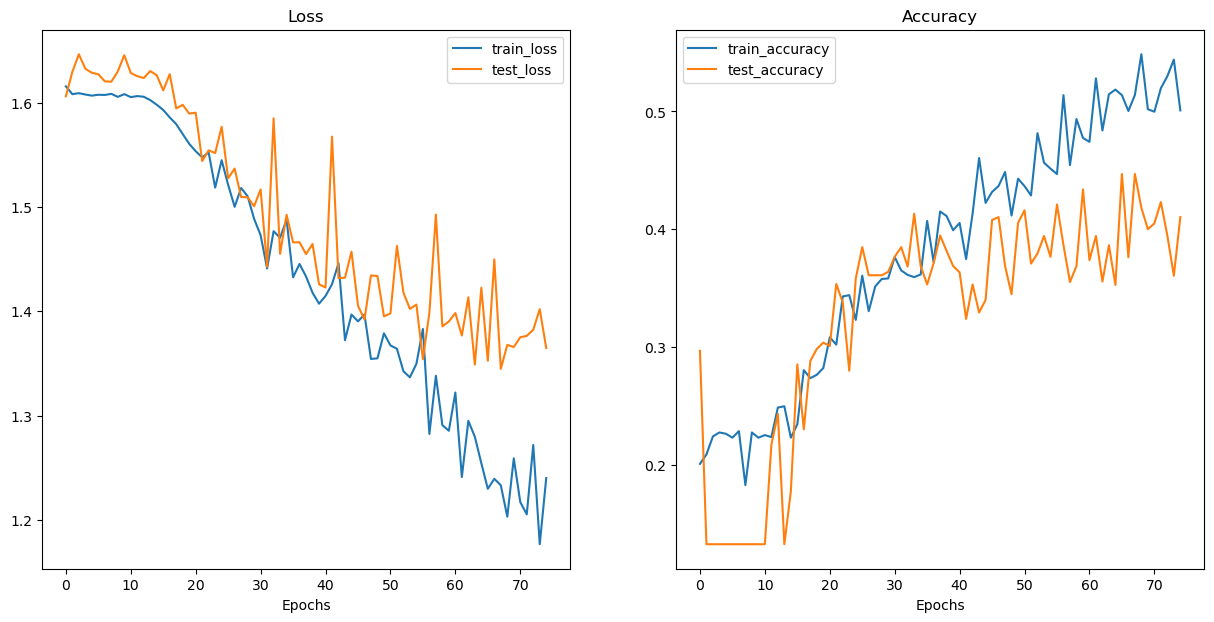

In [57]:
# Set number of epochs
NUM_EPOCHS = 75

model_14 = TinyVGG(
    input_shape=3,
    hidden_units=6,
    output_shape=len(train_data.classes)).to(device)

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_14.parameters(), lr=lr)

# Start the timer
from timeit import default_timer as timer 
start_time = timer()

# Train model_14
model_14_results = train(model=model_14, 
                        train_dataloader=train_dataloader_64,
                        test_dataloader=test_dataloader_64,
                        optimizer=optimizer,
                        loss_fn=loss_fn, 
                        epochs=NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

plot_loss_curves(model_14_results)

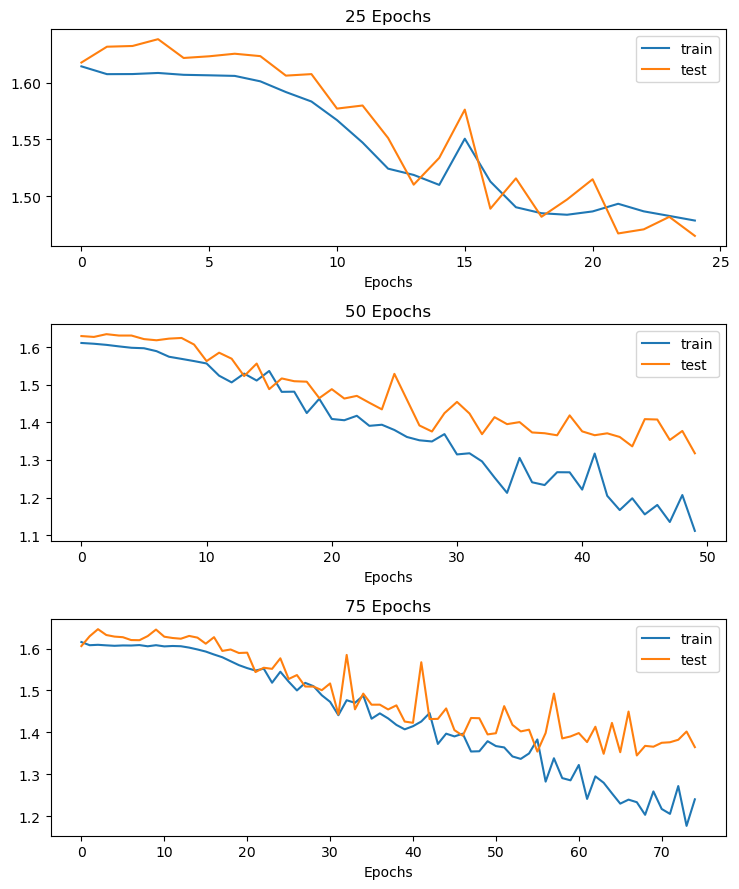

In [91]:
model_12_df = pd.DataFrame(model_12_results)
model_13_df = pd.DataFrame(model_13_results)
model_14_df = pd.DataFrame(model_14_results)

# Setup a plot 
plt.figure(figsize=(7.5, 9))

# Get number of epochs
epochs1 = range(len(model_12_df))
epochs2 = range(len(model_13_df))
epochs3 = range(len(model_14_df))

plt.subplot(3, 1, 1)
plt.plot(epochs1, model_12_df["train_loss"], label="train")
plt.plot(epochs1, model_12_df["test_loss"], label= "test")
plt.title("25 Epochs")
plt.xlabel("Epochs")
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(epochs2, model_13_df["train_loss"], label="train")
plt.plot(epochs2, model_13_df["test_loss"], label= "test")
plt.title("50 Epochs")
plt.xlabel("Epochs")
plt.legend()

# Plot train loss
plt.subplot(3, 1, 3)
plt.plot(epochs3, model_14_df["train_loss"], label="train")
plt.plot(epochs3, model_14_df["test_loss"], label= "test")
plt.title("75 Epochs")
plt.xlabel("Epochs")
plt.legend()

plt.tight_layout()
plt.savefig('epochs_loss')

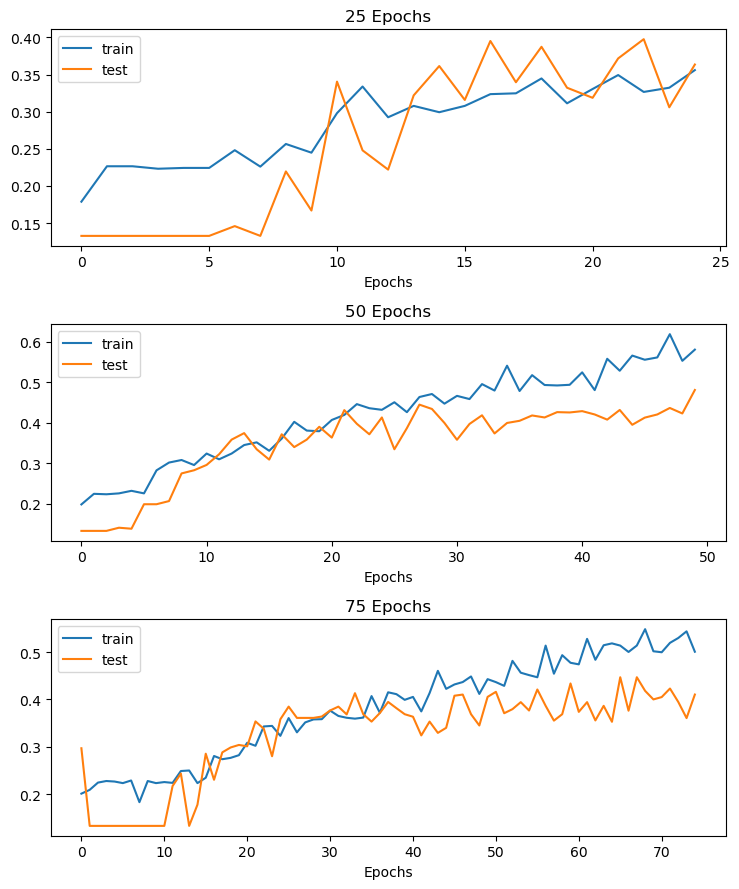

In [92]:
plt.figure(figsize=(7.5, 9))

plt.subplot(3, 1, 1)
plt.plot(epochs1, model_12_df["train_acc"], label="train")
plt.plot(epochs1, model_12_df["test_acc"], label= "test")
plt.title("25 Epochs")
plt.xlabel("Epochs")
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(epochs2, model_13_df["train_acc"], label="train")
plt.plot(epochs2, model_13_df["test_acc"], label= "test")
plt.title("50 Epochs")
plt.xlabel("Epochs")
plt.legend()

# Plot train loss
plt.subplot(3, 1, 3)
plt.plot(epochs3, model_14_df["train_acc"], label="train")
plt.plot(epochs3, model_14_df["test_acc"], label= "test")
plt.title("75 Epochs")
plt.xlabel("Epochs")
plt.legend()

plt.tight_layout()
plt.savefig('epochs_acc')